In [ ]:
try:
    import catboost
except ImportError:
    !pip install catboost

try:
    import xgboost
except ImportError:
    !pip install xgboost

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn import metrics
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import joblib

In [ ]:
df = pd.read_csv("cloudpredictionsystemproject.csv")
pd.set_option("display.max_columns", None)
df

,Date,Location,MinimumTemperature,MaximumTemperature,Rainfall,Evaporation,Sunshine,WindGustDirection,WindGustSpeed,WindDirection9am,WindDirection3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temperature9am,Temperature3pm,CloudBurst Today,CloudBurstTomorrow
0,01-12-2008,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,02-12-2008,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,03-12-2008,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,04-12-2008,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,05-12-2008,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,21-06-2017,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,22-06-2017,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,23-06-2017,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,24-06-2017,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [ ]:
numerical_feature = [feature for feature in df.columns if df[feature].dtypes != 'O']
discrete_feature=[feature for feature in numerical_feature if len(df[feature].unique())<25]
continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature]
categorical_feature = [feature for feature in df.columns if feature not in numerical_feature]
print("Numerical Features Count {}".format(len(numerical_feature)))
print("Discrete feature Count {}".format(len(discrete_feature)))
print("Continuous feature Count {}".format(len(continuous_feature)))
print("Categorical feature Count {}".format(len(categorical_feature)))

Numerical Features Count 16
Discrete feature Count 2
Continuous feature Count 14
Categorical feature Count 7


In [ ]:
# Handle Missing Values
df.isnull().sum()*100/len(df)

Date                   0.000000
Location               0.000000
MinimumTemperature     1.020899
MaximumTemperature     0.866905
Rainfall               2.241853
Evaporation           43.166506
Sunshine              48.009762
WindGustDirection      7.098859
WindGustSpeed          7.055548
WindDirection9am       7.263853
WindDirection3pm       2.906641
WindSpeed9am           1.214767
WindSpeed3pm           2.105046
Humidity9am            1.824557
Humidity3pm            3.098446
Pressure9am           10.356799
Pressure3pm           10.331363
Cloud9am              38.421559
Cloud3pm              40.807095
Temperature9am         1.214767
Temperature3pm         2.481094
CloudBurst Today       2.241853
CloudBurstTomorrow     2.245978
dtype: float64

In [ ]:
print(numerical_feature)

['MinimumTemperature', 'MaximumTemperature', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temperature9am', 'Temperature3pm']


In [ ]:
def randomsampleimputation(df, variable):
    df[variable]=df[variable]
    random_sample=df[variable].dropna().sample(df[variable].isnull().sum(),random_state=0, replace=True)
    random_sample.index=df[df[variable].isnull()].index
    df.loc[df[variable].isnull(),variable]=random_sample

In [ ]:
randomsampleimputation(df, "Cloud9am")
randomsampleimputation(df, "Cloud3pm")
randomsampleimputation(df, "Evaporation")
randomsampleimputation(df, "Sunshine")

In [ ]:
df

,Date,Location,MinimumTemperature,MaximumTemperature,Rainfall,Evaporation,Sunshine,WindGustDirection,WindGustSpeed,WindDirection9am,WindDirection3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temperature9am,Temperature3pm,CloudBurst Today,CloudBurstTomorrow
0,01-12-2008,Albury,13.4,22.9,0.6,0.2,9.8,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,1.0,16.9,21.8,No,No
1,02-12-2008,Albury,7.4,25.1,0.0,2.6,11.9,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,2.0,8.0,17.2,24.3,No,No
2,03-12-2008,Albury,12.9,25.7,0.0,2.0,9.9,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,7.0,2.0,21.0,23.2,No,No
3,04-12-2008,Albury,9.2,28.0,0.0,6.2,9.7,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,7.0,1.0,18.1,26.5,No,No
4,05-12-2008,Albury,17.5,32.3,1.0,3.6,10.9,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,21-06-2017,Uluru,2.8,23.4,0.0,3.6,10.4,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,6.0,10.1,22.4,No,No
145456,22-06-2017,Uluru,3.6,25.3,0.0,3.4,10.2,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,7.0,5.0,10.9,24.5,No,No
145457,23-06-2017,Uluru,5.4,26.9,0.0,0.6,0.9,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,1.0,1.0,12.5,26.1,No,No
145458,24-06-2017,Uluru,7.8,27.0,0.0,3.4,0.0,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [ ]:
# Skip correlation plot here - will do it after encoding categorical features
print("Correlation plot will be generated after encoding categorical features")

Correlation plot will be generated after encoding categorical features


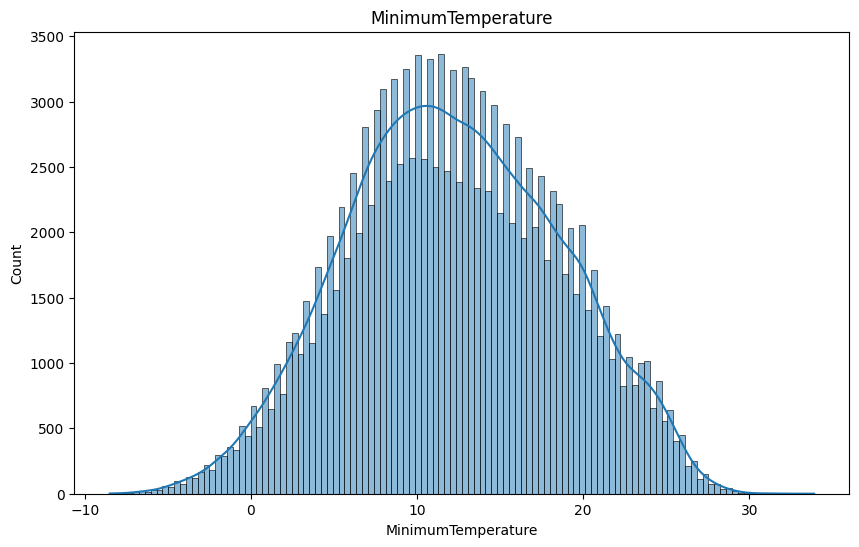

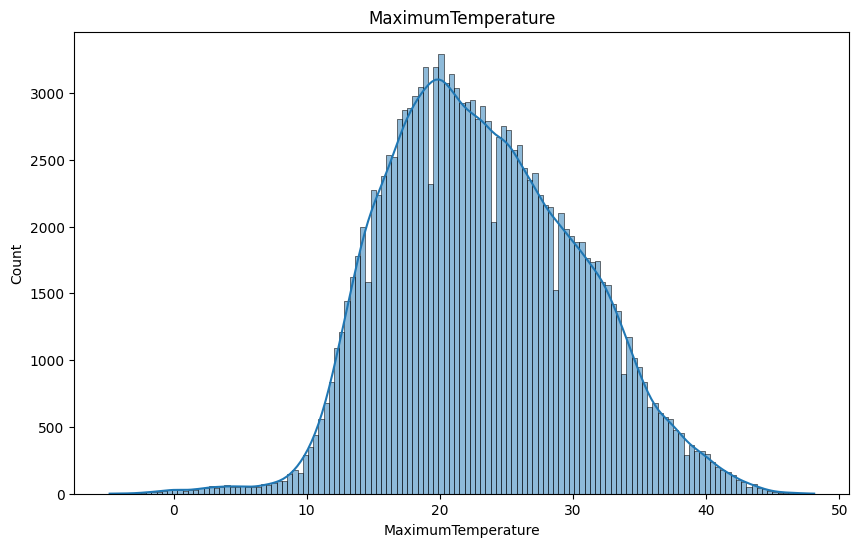

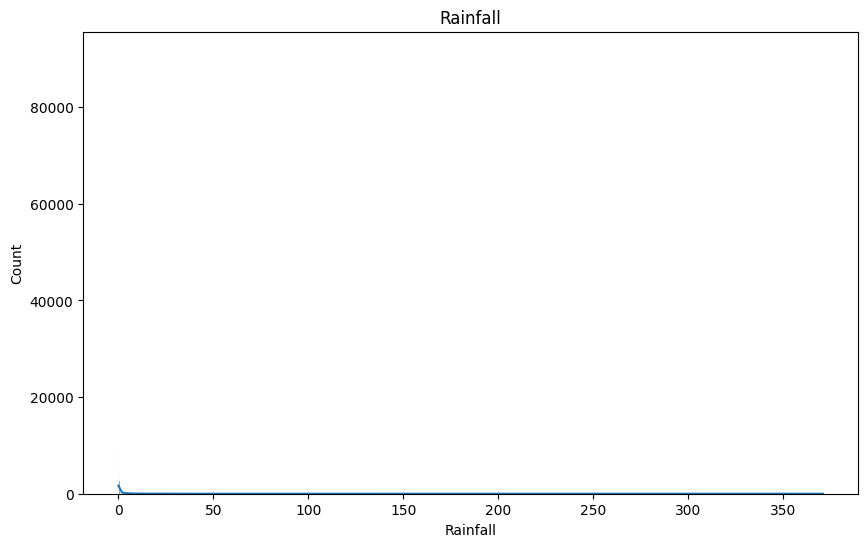

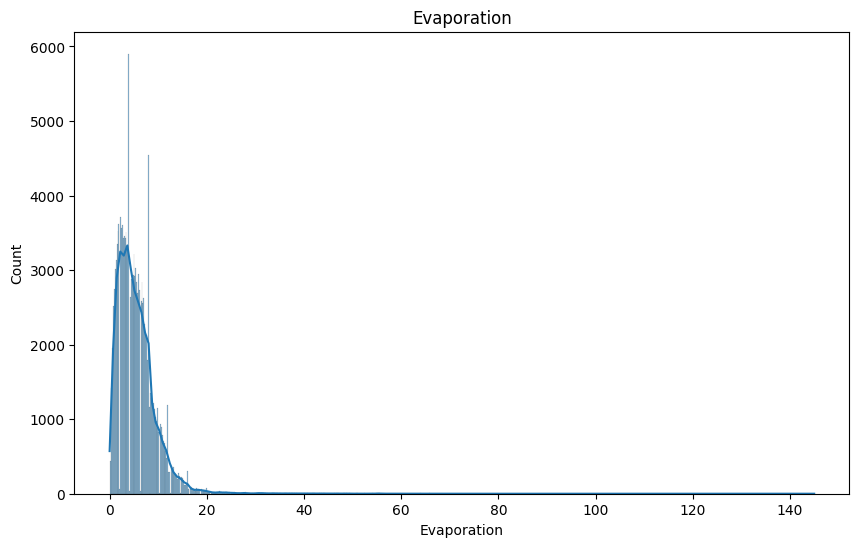

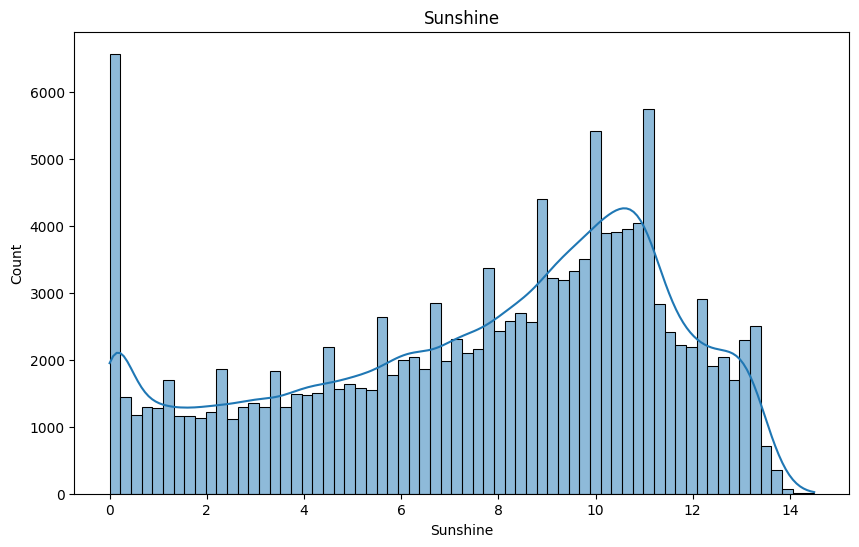

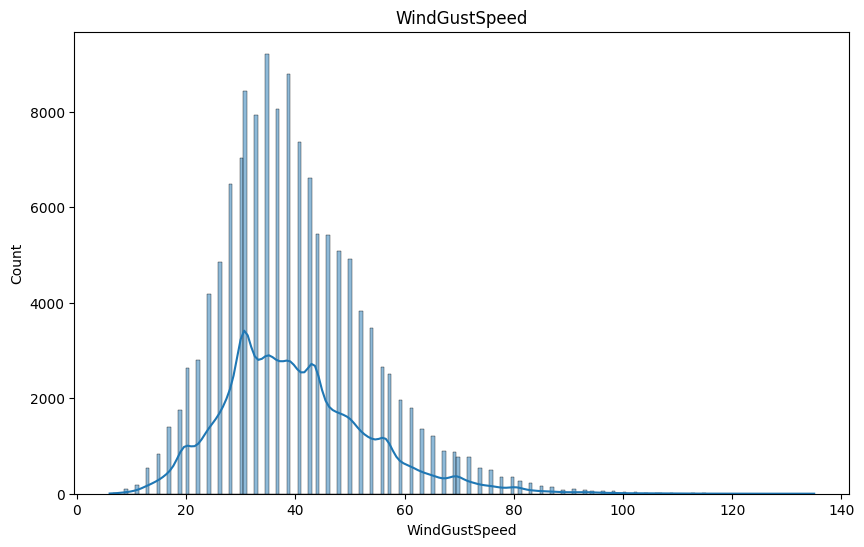

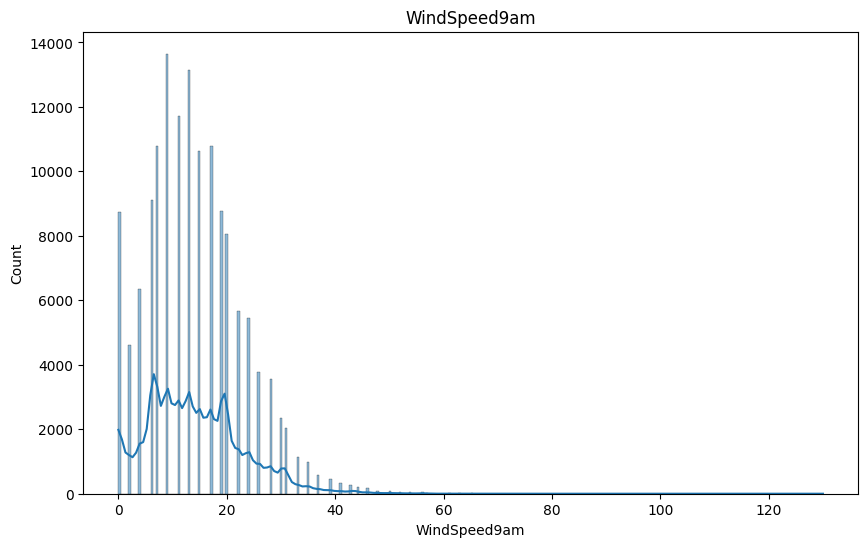

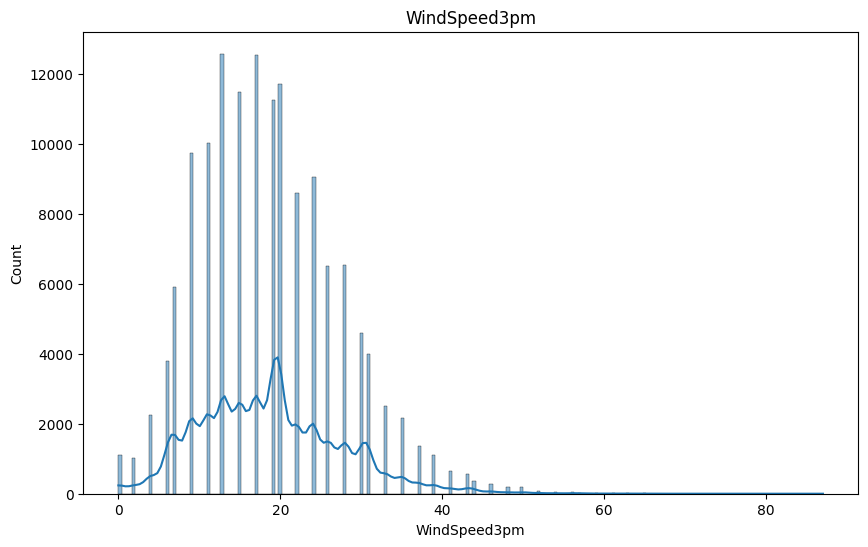

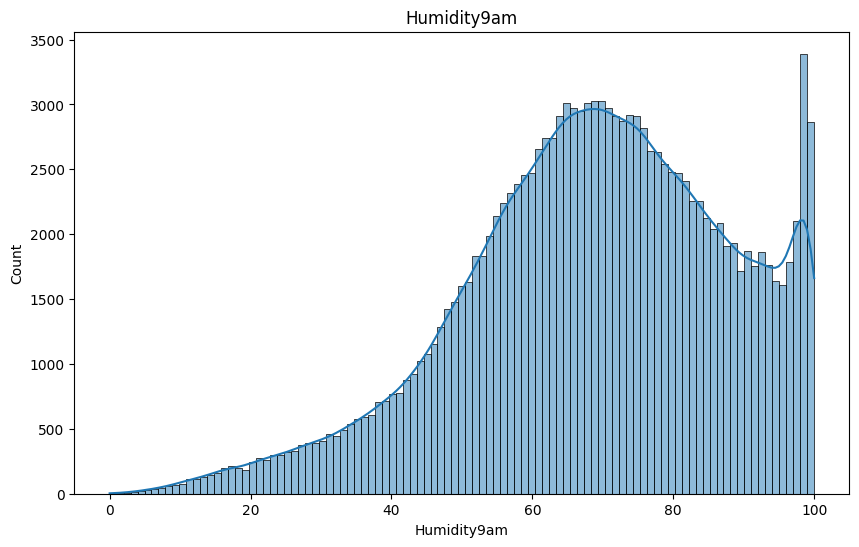

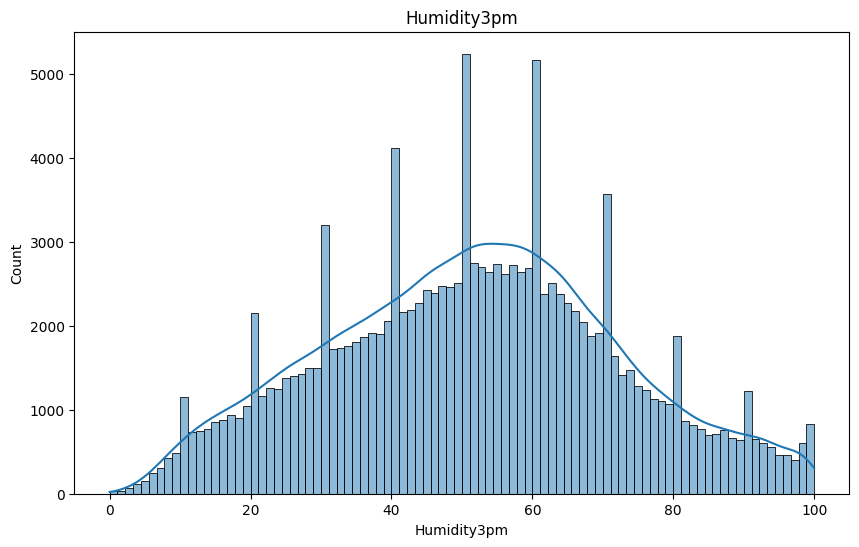

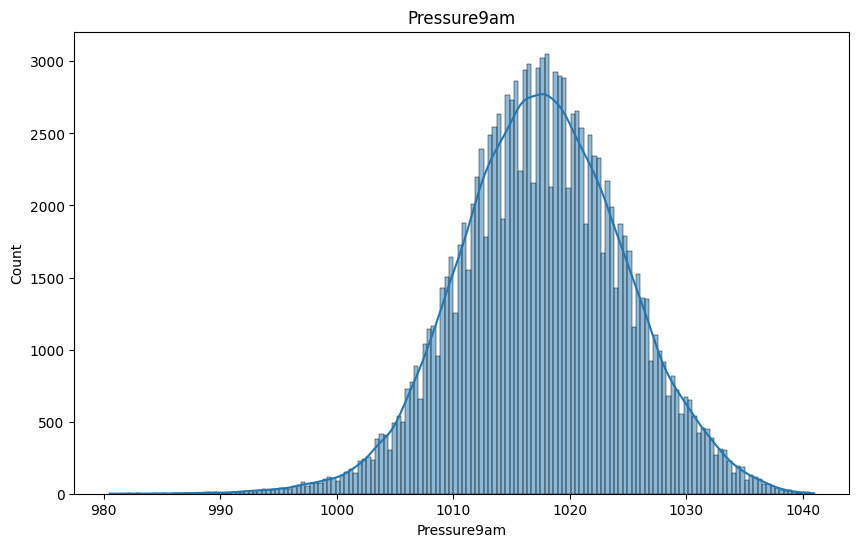

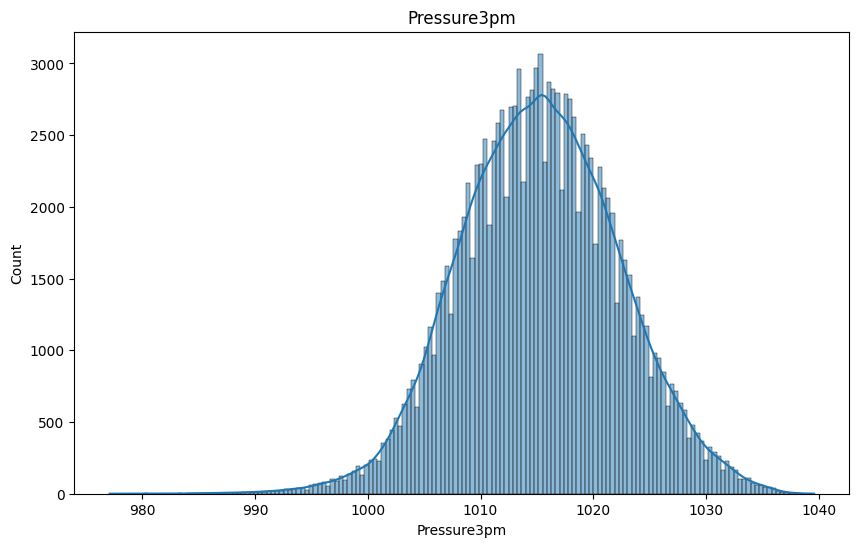

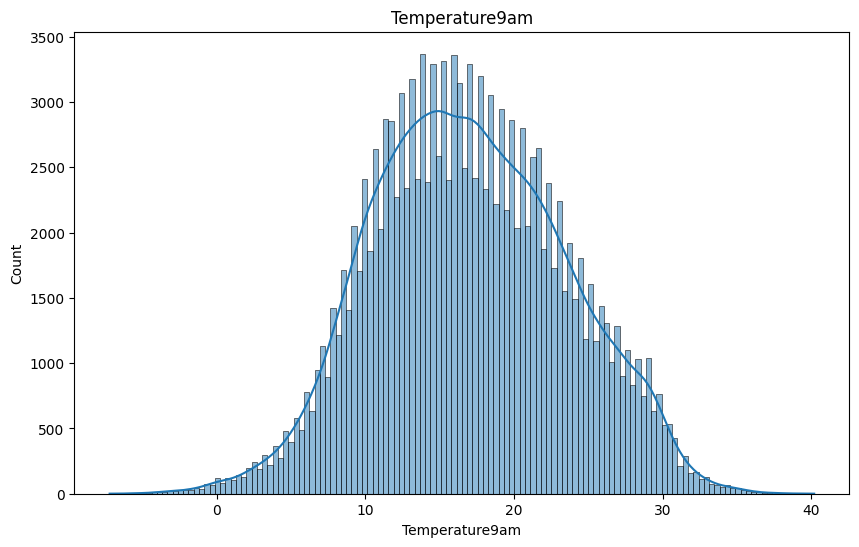

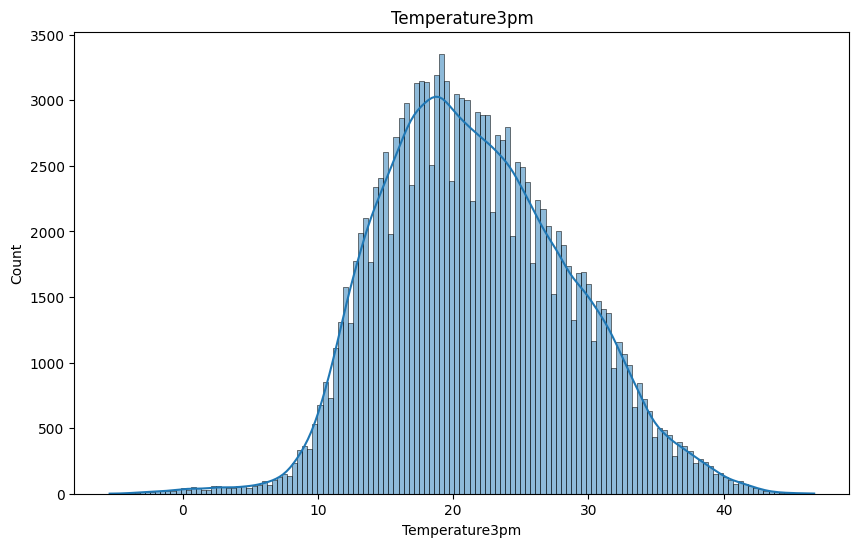

In [ ]:
for feature in continuous_feature:
    data=df.copy()
    plt.figure(figsize=(10,6))
    sns.histplot(df[feature], kde=True)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

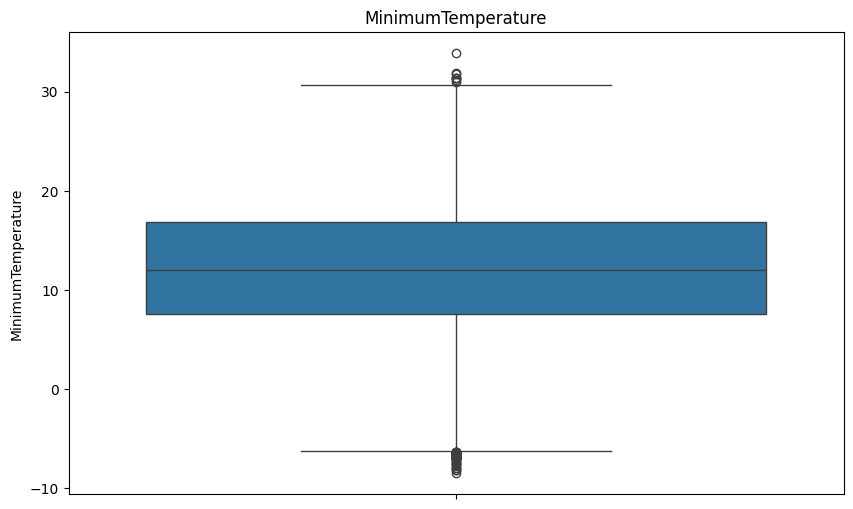

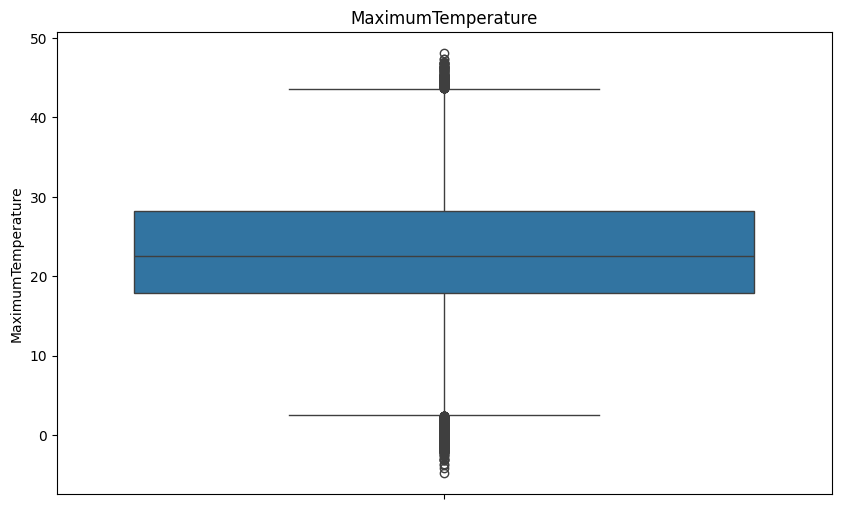

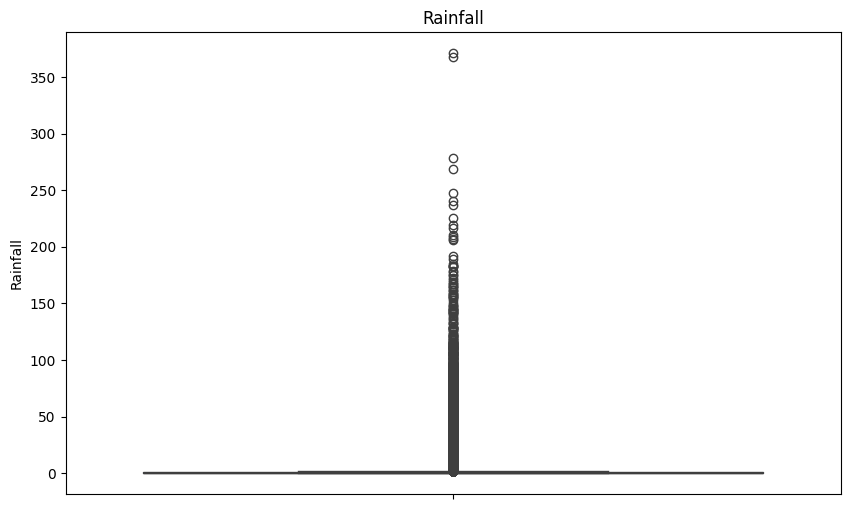

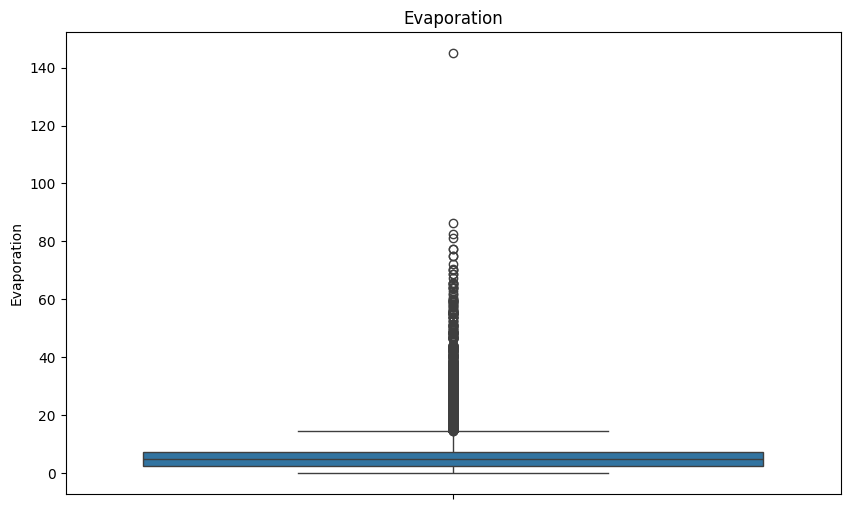

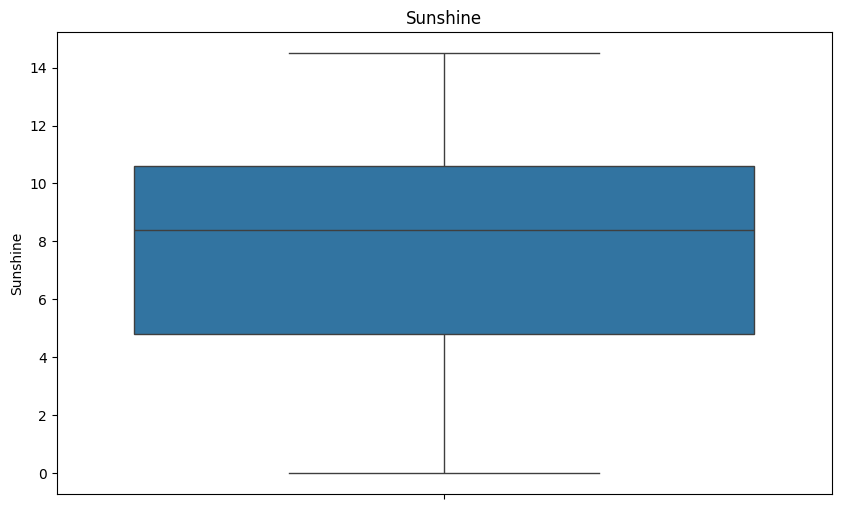

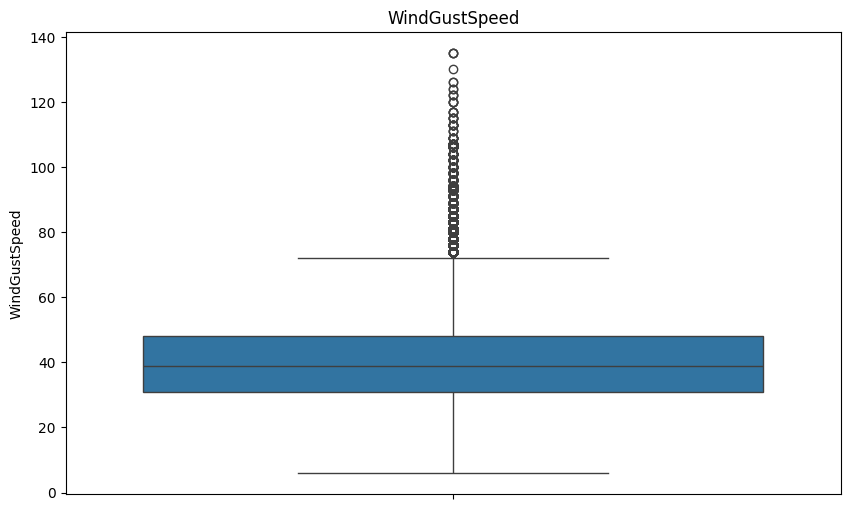

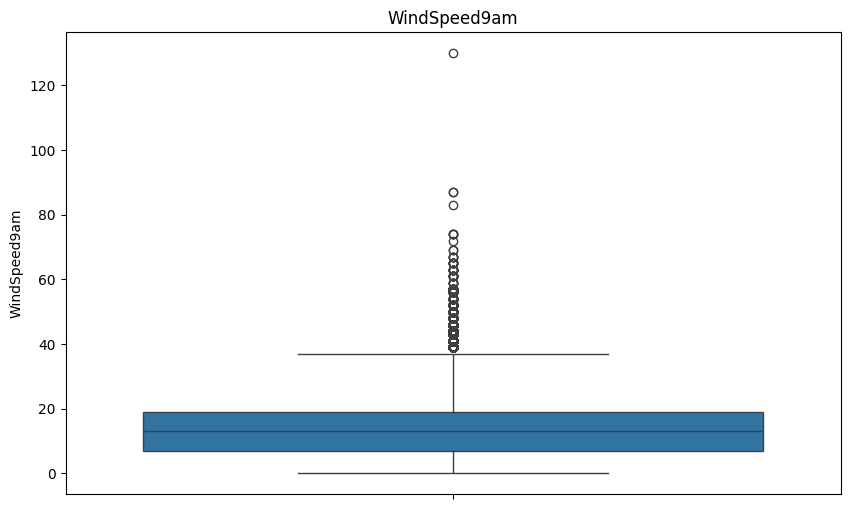

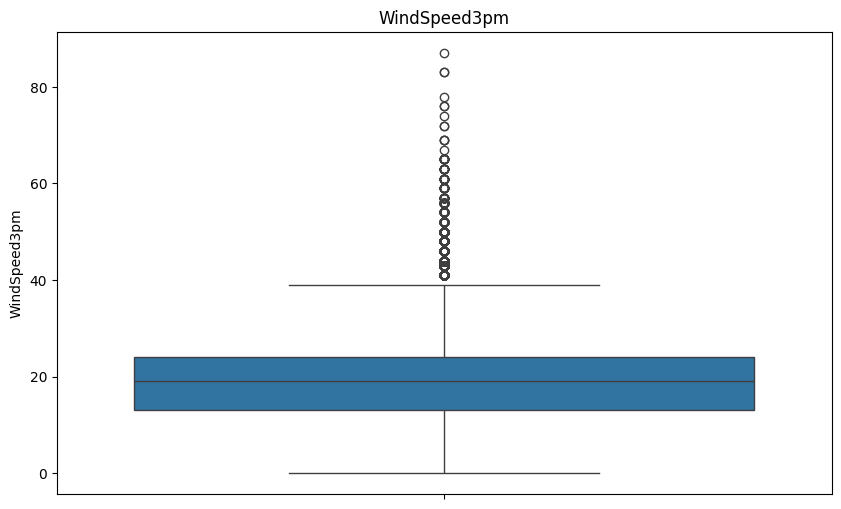

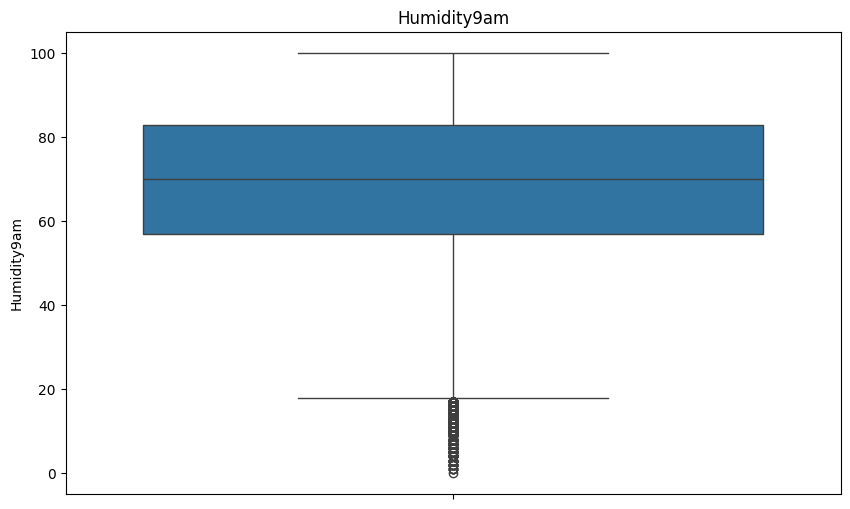

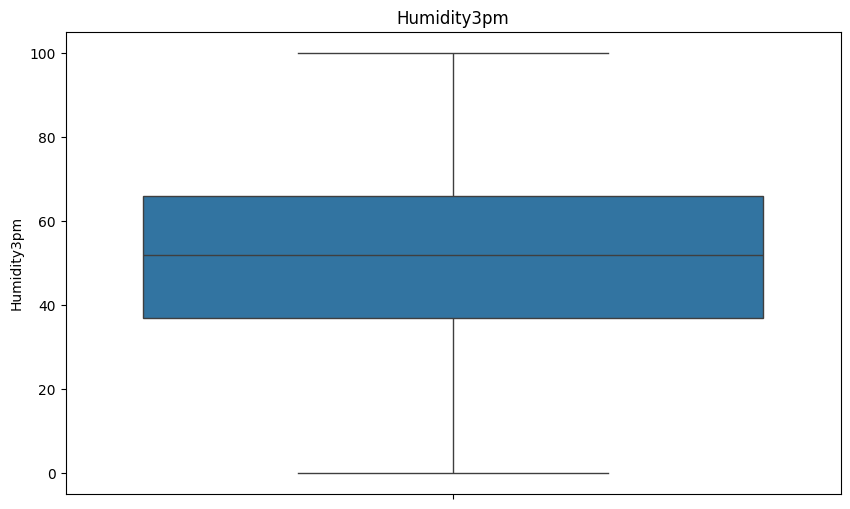

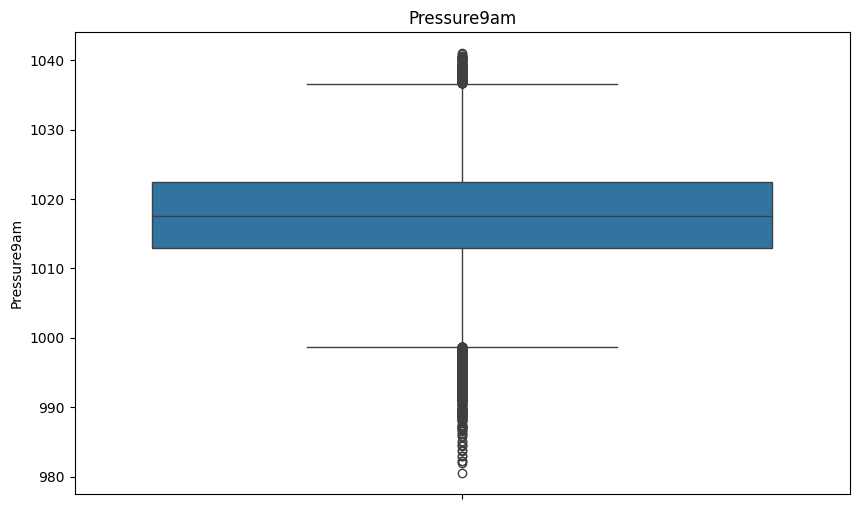

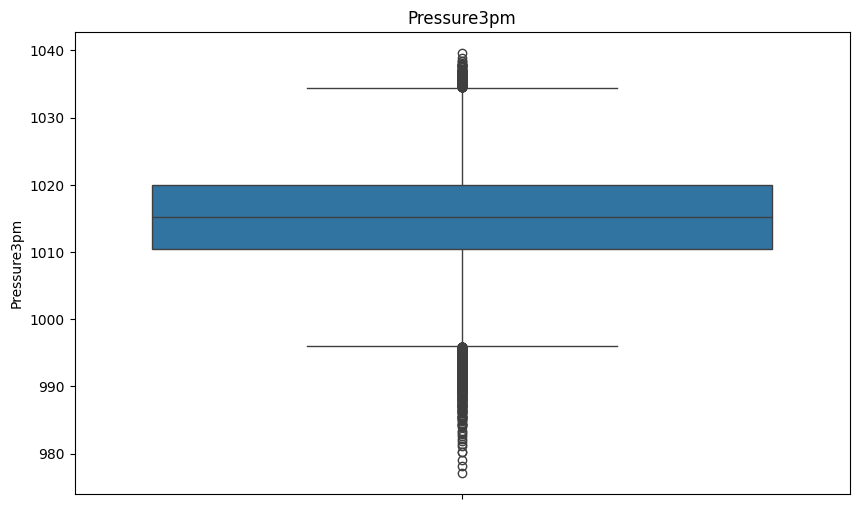

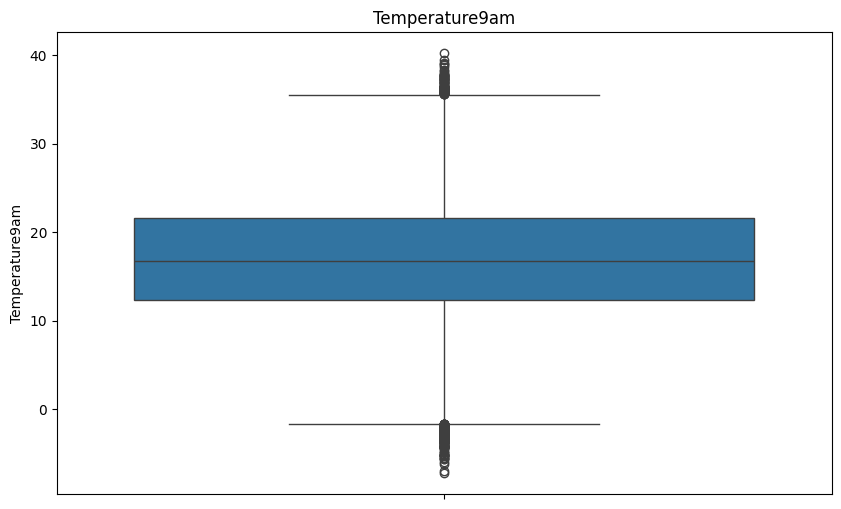

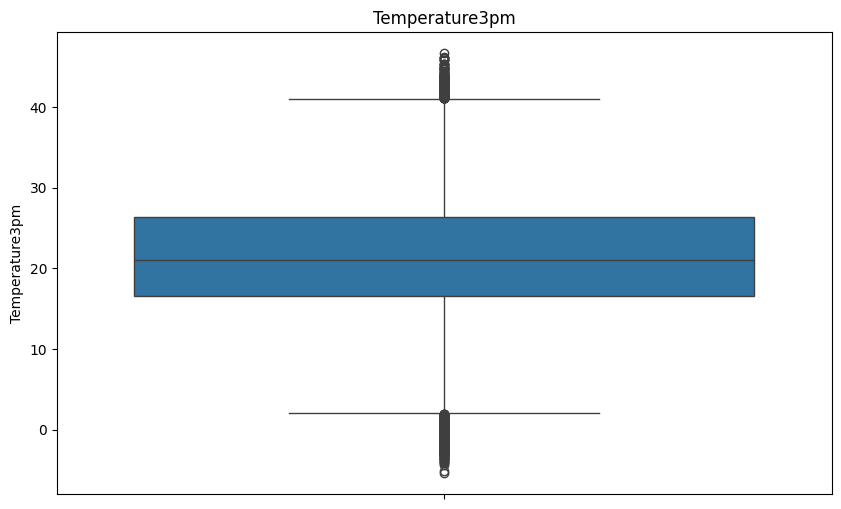

In [ ]:
#A for loop is used to plot a boxplot for all the continuous features to see the outliers
for feature in continuous_feature:
    data=df.copy()
    plt.figure(figsize=(10,6))
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.show()

In [ ]:
for feature in continuous_feature:
    if(df[feature].isnull().sum()*100/len(df))>0:
        df[feature] = df[feature].fillna(df[feature].median())

In [ ]:
df.isnull().sum()*100/len(df)

Date                  0.000000
Location              0.000000
MinimumTemperature    0.000000
MaximumTemperature    0.000000
Rainfall              0.000000
Evaporation           0.000000
Sunshine              0.000000
WindGustDirection     7.098859
WindGustSpeed         0.000000
WindDirection9am      7.263853
WindDirection3pm      2.906641
WindSpeed9am          0.000000
WindSpeed3pm          0.000000
Humidity9am           0.000000
Humidity3pm           0.000000
Pressure9am           0.000000
Pressure3pm           0.000000
Cloud9am              0.000000
Cloud3pm              0.000000
Temperature9am        0.000000
Temperature3pm        0.000000
CloudBurst Today      2.241853
CloudBurstTomorrow    2.245978
dtype: float64

In [ ]:
discrete_feature

['Cloud9am', 'Cloud3pm']

In [ ]:
def mode_nan(df,variable):
    mode=df[variable].value_counts().index[0]
    df[variable].fillna(mode,inplace=True)
mode_nan(df,"Cloud9am")
mode_nan(df,"Cloud3pm")

C:\Users\cvbal\AppData\Local\Temp\ipykernel_27760\2340639285.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[variable].fillna(mode,inplace=True)


In [ ]:
df["CloudBurst Today"] = pd.get_dummies(df["CloudBurst Today"], drop_first = True)
df["CloudBurstTomorrow"] = pd.get_dummies(df["CloudBurstTomorrow"], drop_first = True)
df

,Date,Location,MinimumTemperature,MaximumTemperature,Rainfall,Evaporation,Sunshine,WindGustDirection,WindGustSpeed,WindDirection9am,WindDirection3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temperature9am,Temperature3pm,CloudBurst Today,CloudBurstTomorrow
0,01-12-2008,Albury,13.4,22.9,0.6,0.2,9.8,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,1.0,16.9,21.8,False,False
1,02-12-2008,Albury,7.4,25.1,0.0,2.6,11.9,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,2.0,8.0,17.2,24.3,False,False
2,03-12-2008,Albury,12.9,25.7,0.0,2.0,9.9,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,7.0,2.0,21.0,23.2,False,False
3,04-12-2008,Albury,9.2,28.0,0.0,6.2,9.7,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,7.0,1.0,18.1,26.5,False,False
4,05-12-2008,Albury,17.5,32.3,1.0,3.6,10.9,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,21-06-2017,Uluru,2.8,23.4,0.0,3.6,10.4,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,6.0,10.1,22.4,False,False
145456,22-06-2017,Uluru,3.6,25.3,0.0,3.4,10.2,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,7.0,5.0,10.9,24.5,False,False
145457,23-06-2017,Uluru,5.4,26.9,0.0,0.6,0.9,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,1.0,1.0,12.5,26.1,False,False
145458,24-06-2017,Uluru,7.8,27.0,0.0,3.4,0.0,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,False,False


In [ ]:
for feature in categorical_feature:
    print(feature, (df.groupby([feature])["CloudBurstTomorrow"].mean().sort_values(ascending = False)).index)

Date Index(['19-12-2007', '30-01-2008', '24-12-2007', '13-04-2008', '19-06-2008',
       '02-11-2007', '03-11-2007', '20-12-2007', '03-12-2007', '21-12-2007',
       ...
       '29-04-2008', '25-04-2008', '14-01-2008', '14-02-2008', '19-08-2008',
       '29-03-2008', '29-02-2008', '08-03-2008', '19-07-2008', '01-01-2008'],
      dtype='object', name='Date', length=3436)
Location Index(['Portland', 'Walpole', 'Cairns', 'Dartmoor', 'NorfolkIsland',
       'MountGambier', 'Albany', 'Witchcliffe', 'CoffsHarbour', 'MountGinini',
       'NorahHead', 'Darwin', 'Sydney', 'SydneyAirport', 'Ballarat',
       'GoldCoast', 'Watsonia', 'Newcastle', 'Hobart', 'Wollongong',
       'Williamtown', 'Launceston', 'Brisbane', 'MelbourneAirport', 'Adelaide',
       'Sale', 'Albury', 'Perth', 'Melbourne', 'Nuriootpa', 'Penrith',
       'BadgerysCreek', 'PerthAirport', 'Tuggeranong', 'Richmond', 'Bendigo',
       'Canberra', 'WaggaWagga', 'Townsville', 'Katherine', 'PearceRAAF',
       'SalmonGums', 'Nhil', 

In [ ]:
windgustdir = {'NNW':0, 'NW':1, 'WNW':2, 'N':3, 'W':4, 'WSW':5, 'NNE':6, 'S':7, 'SSW':8, 'SW':9, 'SSE':10,
       'NE':11, 'SE':12, 'ESE':13, 'ENE':14, 'E':15}
winddir9am = {'NNW':0, 'N':1, 'NW':2, 'NNE':3, 'WNW':4, 'W':5, 'WSW':6, 'SW':7, 'SSW':8, 'NE':9, 'S':10,
       'SSE':11, 'ENE':12, 'SE':13, 'ESE':14, 'E':15}
winddir3pm = {'NW':0, 'NNW':1, 'N':2, 'WNW':3, 'W':4, 'NNE':5, 'WSW':6, 'SSW':7, 'S':8, 'SW':9, 'SE':10,
       'NE':11, 'SSE':12, 'ENE':13, 'E':14, 'ESE':15}
df["WindGustDirection"] = df["WindGustDirection"].map(windgustdir)
df["WindDirection9am"] = df["WindDirection9am"].map(winddir9am)
df["WindDirection3pm"] = df["WindDirection3pm"].map(winddir3pm)

In [ ]:
df["WindGustDirection"] = df["WindGustDirection"].fillna(df["WindGustDirection"].value_counts().index[0])
df["WindDirection9am"] = df["WindDirection9am"].fillna(df["WindDirection9am"].value_counts().index[0])
df["WindDirection3pm"] = df["WindDirection3pm"].fillna(df["WindDirection3pm"].value_counts().index[0])

In [ ]:
df.isnull().sum()*100/len(df)

Date                  0.0
Location              0.0
MinimumTemperature    0.0
MaximumTemperature    0.0
Rainfall              0.0
Evaporation           0.0
Sunshine              0.0
WindGustDirection     0.0
WindGustSpeed         0.0
WindDirection9am      0.0
WindDirection3pm      0.0
WindSpeed9am          0.0
WindSpeed3pm          0.0
Humidity9am           0.0
Humidity3pm           0.0
Pressure9am           0.0
Pressure3pm           0.0
Cloud9am              0.0
Cloud3pm              0.0
Temperature9am        0.0
Temperature3pm        0.0
CloudBurst Today      0.0
CloudBurstTomorrow    0.0
dtype: float64

In [ ]:
encoder = preprocessing.LabelEncoder()
df['Location']= encoder.fit_transform(df['Location'])

In [ ]:
df["Date"] = pd.to_datetime(df["Date"], format = "%d-%m-%Y", errors = "coerce")

In [ ]:
df["Date_year"] = df["Date"].dt.year
df["Date_month"] = df["Date"].dt.month
df["Date_day"] = df["Date"].dt.day

In [ ]:
df

,Date,Location,MinimumTemperature,MaximumTemperature,Rainfall,Evaporation,Sunshine,WindGustDirection,WindGustSpeed,WindDirection9am,WindDirection3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temperature9am,Temperature3pm,CloudBurst Today,CloudBurstTomorrow,Date_year,Date_month,Date_day
0,2008-12-01,2,13.4,22.9,0.6,0.2,9.8,4.0,44.0,5.0,3.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,1.0,16.9,21.8,False,False,2008,12,1
1,2008-12-02,2,7.4,25.1,0.0,2.6,11.9,2.0,44.0,0.0,6.0,4.0,22.0,44.0,25.0,1010.6,1007.8,2.0,8.0,17.2,24.3,False,False,2008,12,2
2,2008-12-03,2,12.9,25.7,0.0,2.0,9.9,5.0,46.0,5.0,6.0,19.0,26.0,38.0,30.0,1007.6,1008.7,7.0,2.0,21.0,23.2,False,False,2008,12,3
3,2008-12-04,2,9.2,28.0,0.0,6.2,9.7,11.0,24.0,13.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,7.0,1.0,18.1,26.5,False,False,2008,12,4
4,2008-12-05,2,17.5,32.3,1.0,3.6,10.9,4.0,41.0,12.0,0.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,False,False,2008,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,41,2.8,23.4,0.0,3.6,10.4,15.0,31.0,13.0,13.0,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,6.0,10.1,22.4,False,False,2017,6,21
145456,2017-06-22,41,3.6,25.3,0.0,3.4,10.2,0.0,22.0,13.0,2.0,13.0,9.0,56.0,21.0,1023.5,1019.1,7.0,5.0,10.9,24.5,False,False,2017,6,22
145457,2017-06-23,41,5.4,26.9,0.0,0.6,0.9,3.0,37.0,13.0,3.0,9.0,9.0,53.0,24.0,1021.0,1016.8,1.0,1.0,12.5,26.1,False,False,2017,6,23
145458,2017-06-24,41,7.8,27.0,0.0,3.4,0.0,12.0,28.0,11.0,2.0,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,False,False,2017,6,24


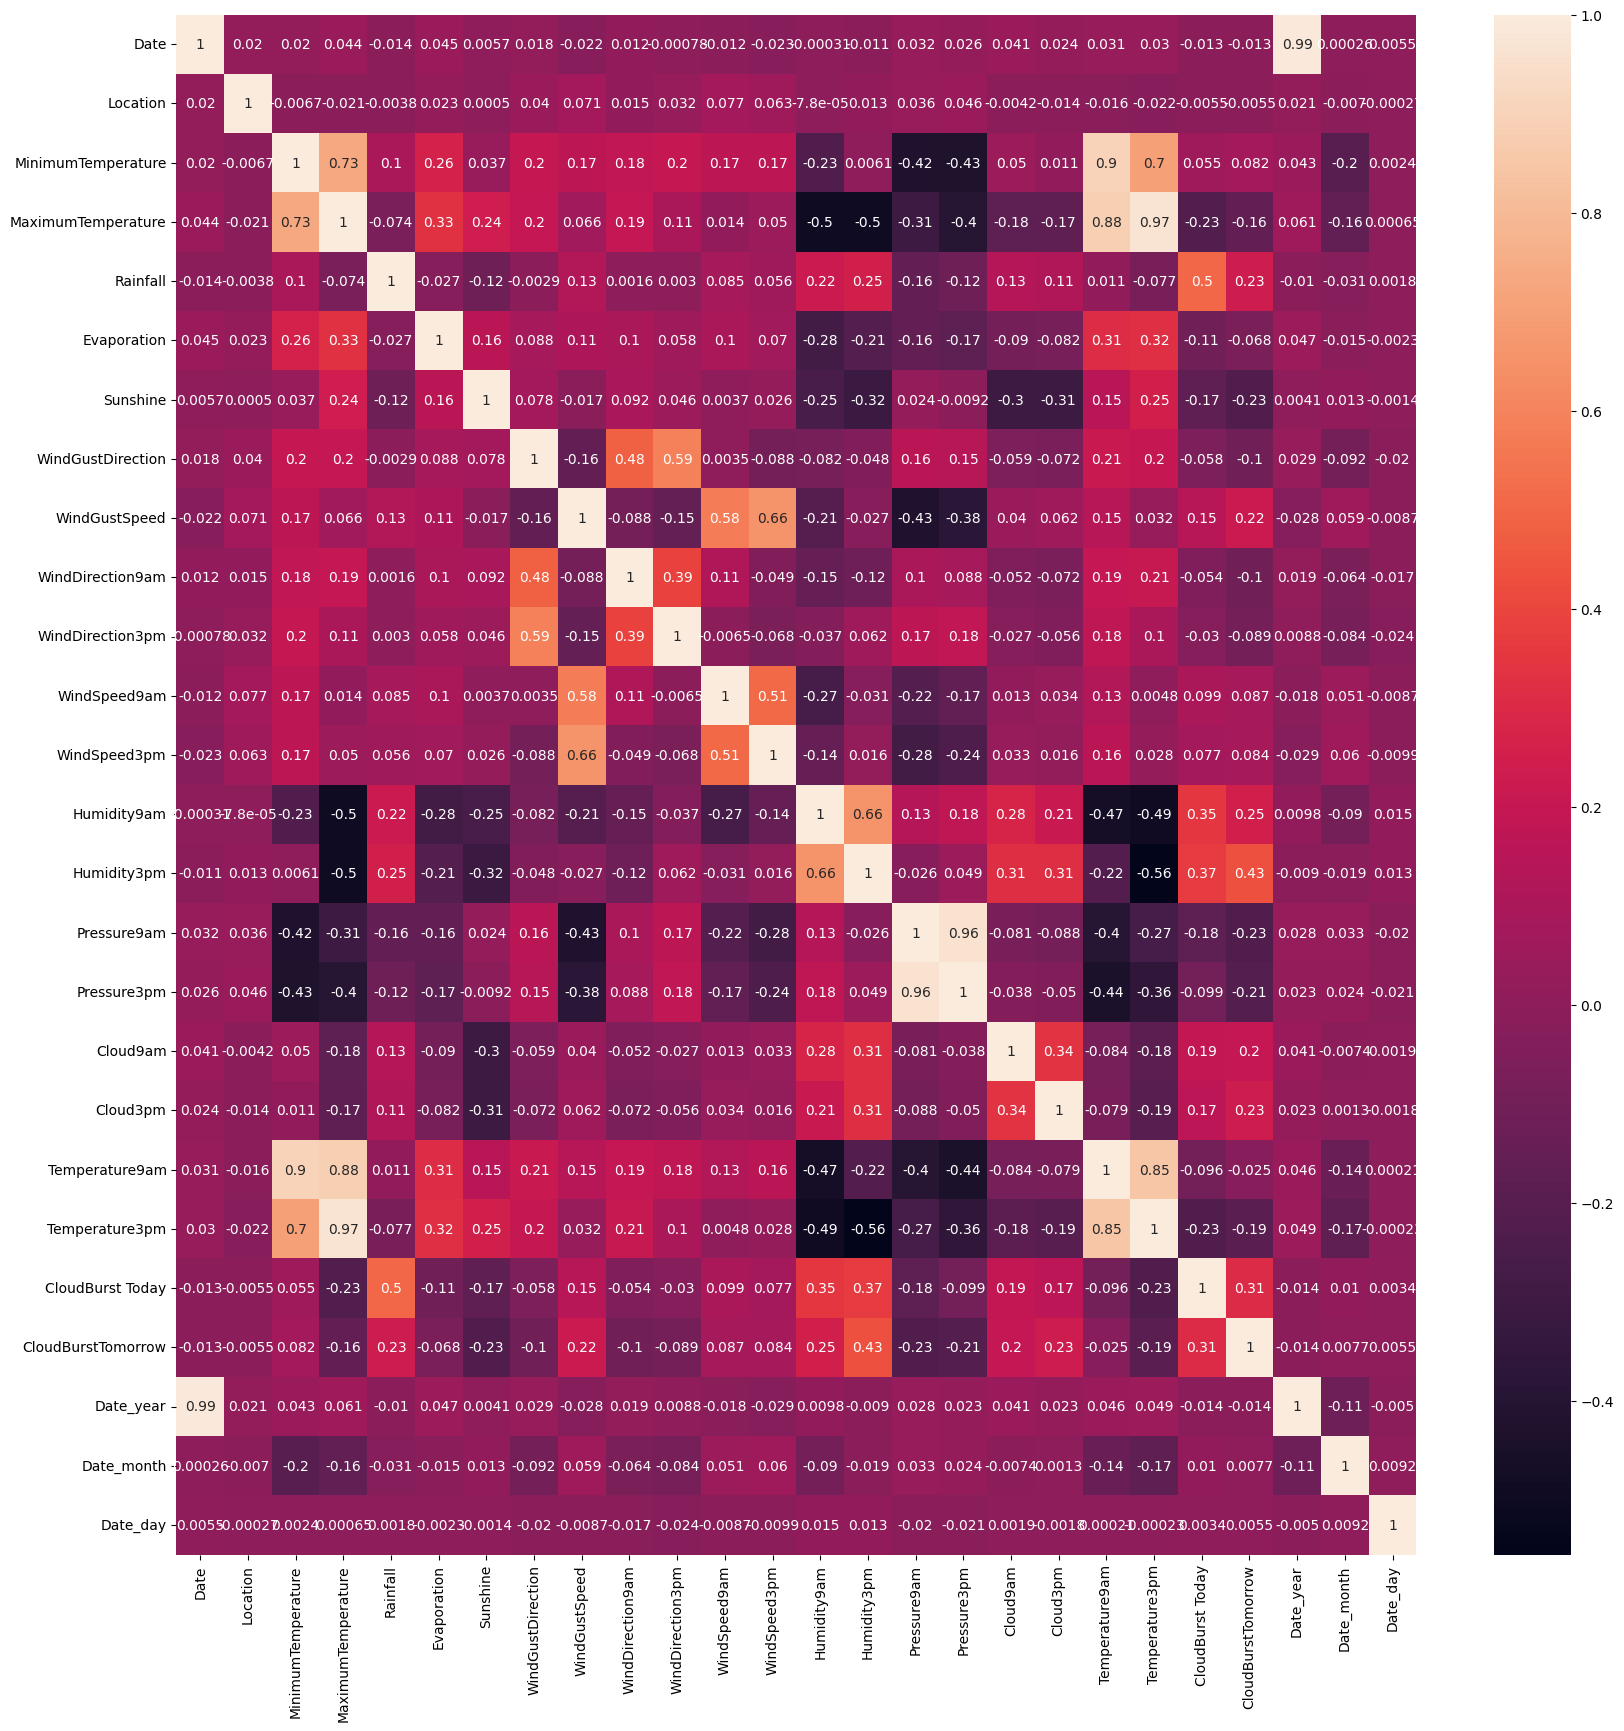

In [ ]:
corrmat = df.corr()
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(corrmat,annot=True)

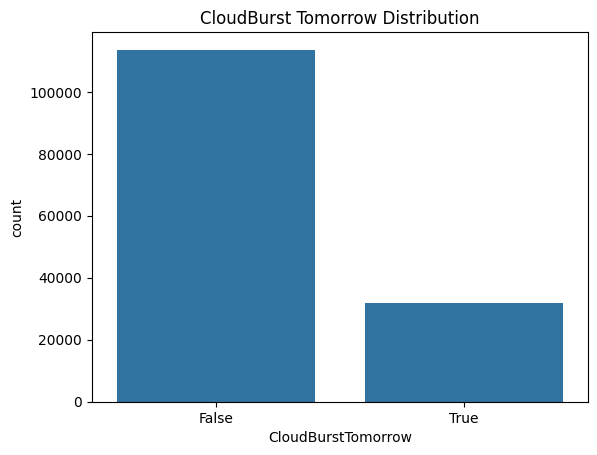

In [ ]:
sns.countplot(x=df["CloudBurstTomorrow"])
plt.title("CloudBurst Tomorrow Distribution")
plt.show()

In [ ]:
df

,Date,Location,MinimumTemperature,MaximumTemperature,Rainfall,Evaporation,Sunshine,WindGustDirection,WindGustSpeed,WindDirection9am,WindDirection3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temperature9am,Temperature3pm,CloudBurst Today,CloudBurstTomorrow,Date_year,Date_month,Date_day
0,2008-12-01,2,13.4,22.9,0.6,0.2,9.8,4.0,44.0,5.0,3.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,1.0,16.9,21.8,False,False,2008,12,1
1,2008-12-02,2,7.4,25.1,0.0,2.6,11.9,2.0,44.0,0.0,6.0,4.0,22.0,44.0,25.0,1010.6,1007.8,2.0,8.0,17.2,24.3,False,False,2008,12,2
2,2008-12-03,2,12.9,25.7,0.0,2.0,9.9,5.0,46.0,5.0,6.0,19.0,26.0,38.0,30.0,1007.6,1008.7,7.0,2.0,21.0,23.2,False,False,2008,12,3
3,2008-12-04,2,9.2,28.0,0.0,6.2,9.7,11.0,24.0,13.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,7.0,1.0,18.1,26.5,False,False,2008,12,4
4,2008-12-05,2,17.5,32.3,1.0,3.6,10.9,4.0,41.0,12.0,0.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,False,False,2008,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,41,2.8,23.4,0.0,3.6,10.4,15.0,31.0,13.0,13.0,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,6.0,10.1,22.4,False,False,2017,6,21
145456,2017-06-22,41,3.6,25.3,0.0,3.4,10.2,0.0,22.0,13.0,2.0,13.0,9.0,56.0,21.0,1023.5,1019.1,7.0,5.0,10.9,24.5,False,False,2017,6,22
145457,2017-06-23,41,5.4,26.9,0.0,0.6,0.9,3.0,37.0,13.0,3.0,9.0,9.0,53.0,24.0,1021.0,1016.8,1.0,1.0,12.5,26.1,False,False,2017,6,23
145458,2017-06-24,41,7.8,27.0,0.0,3.4,0.0,12.0,28.0,11.0,2.0,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,False,False,2017,6,24


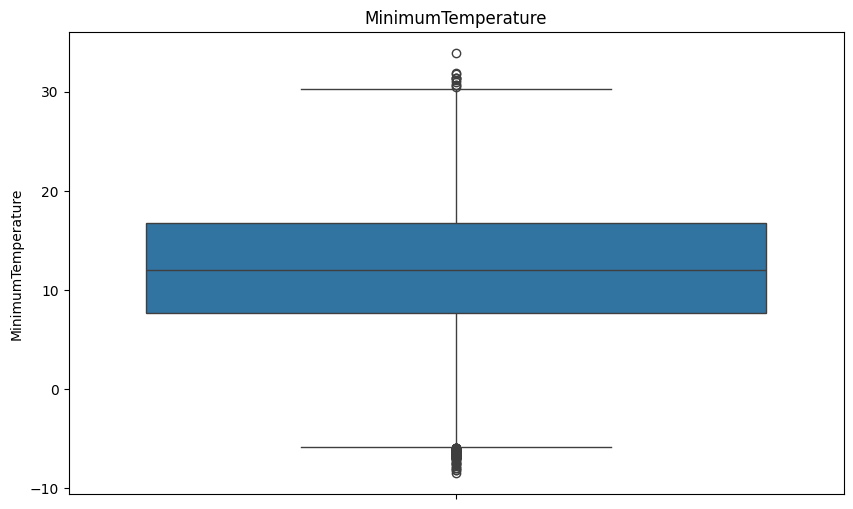

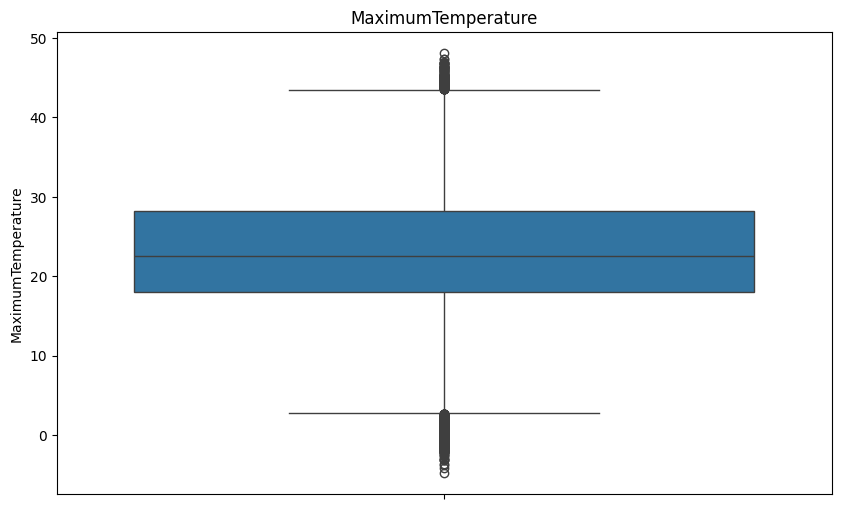

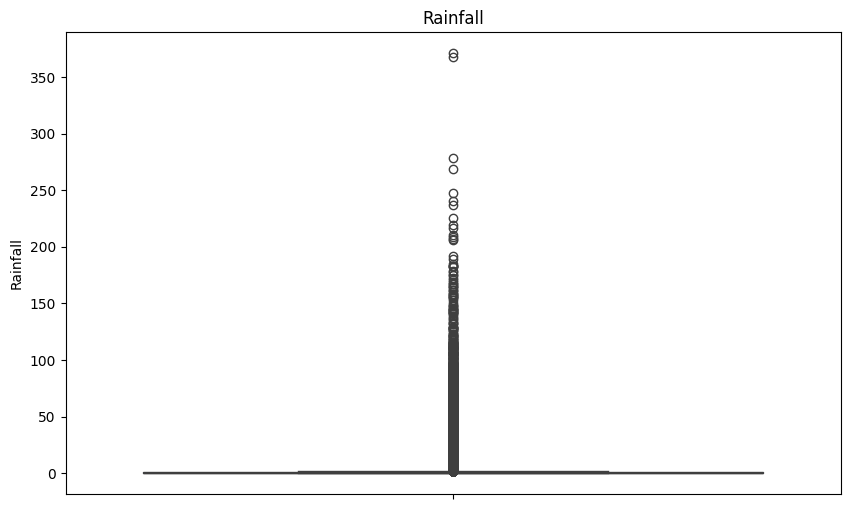

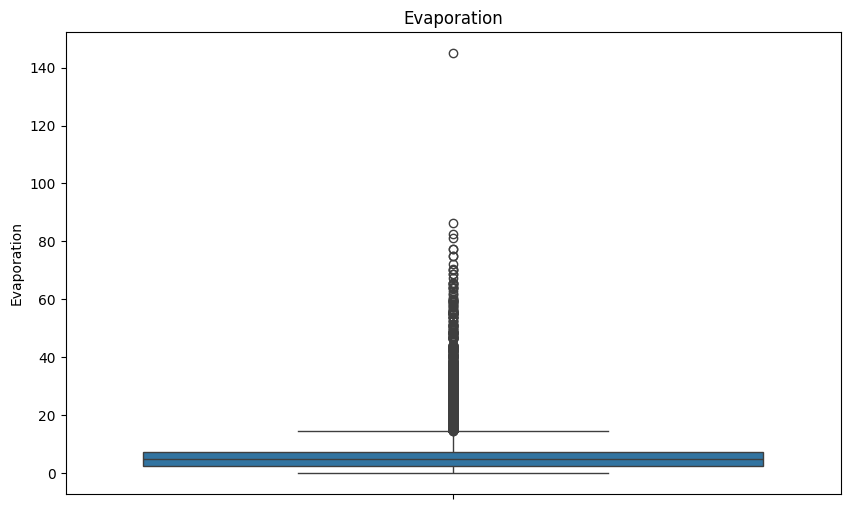

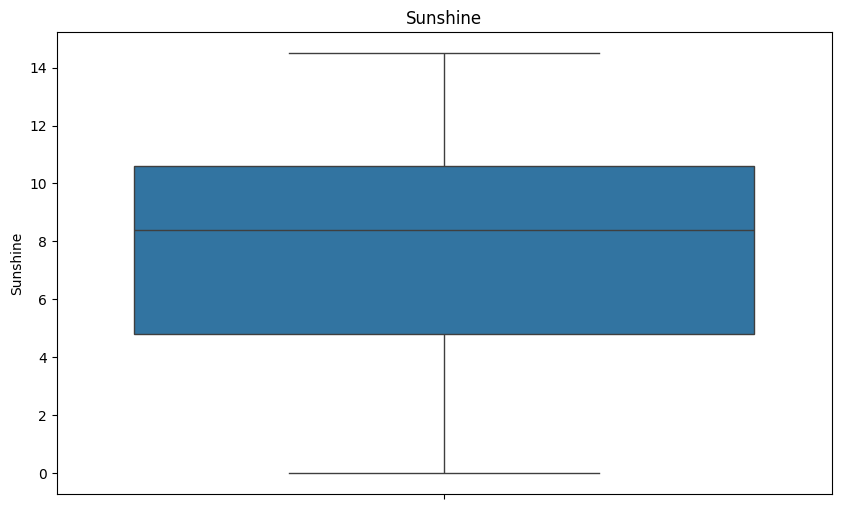

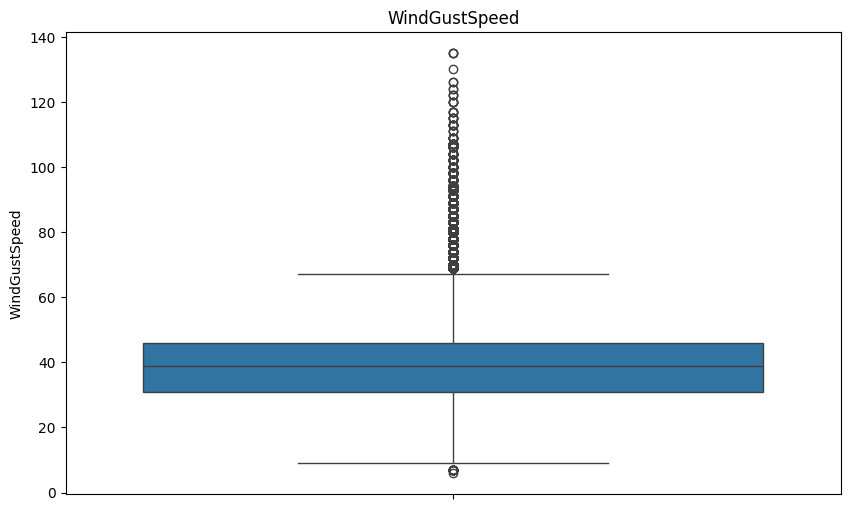

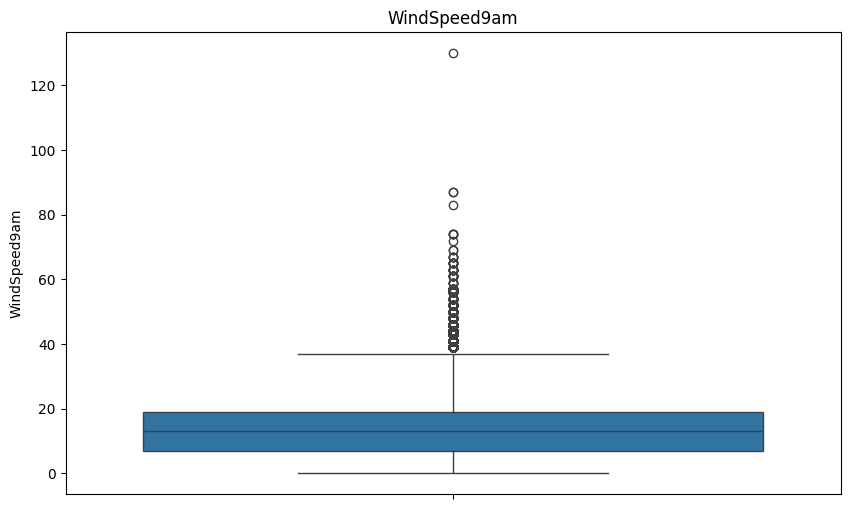

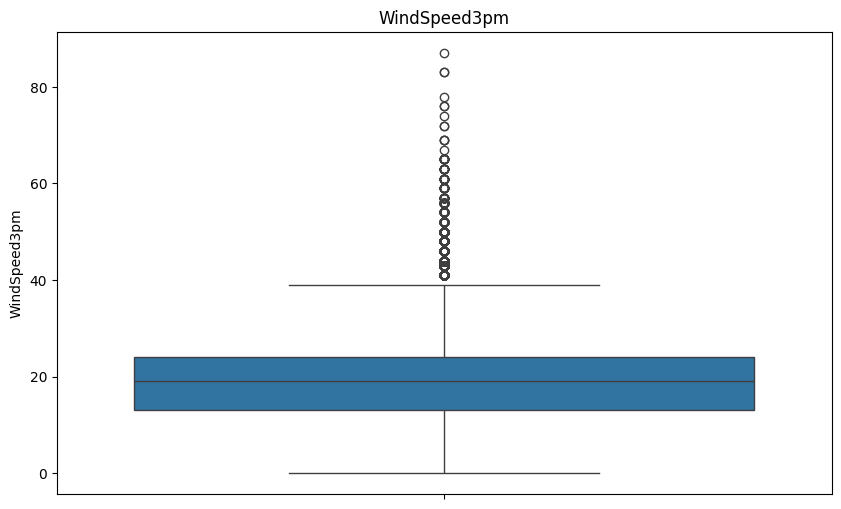

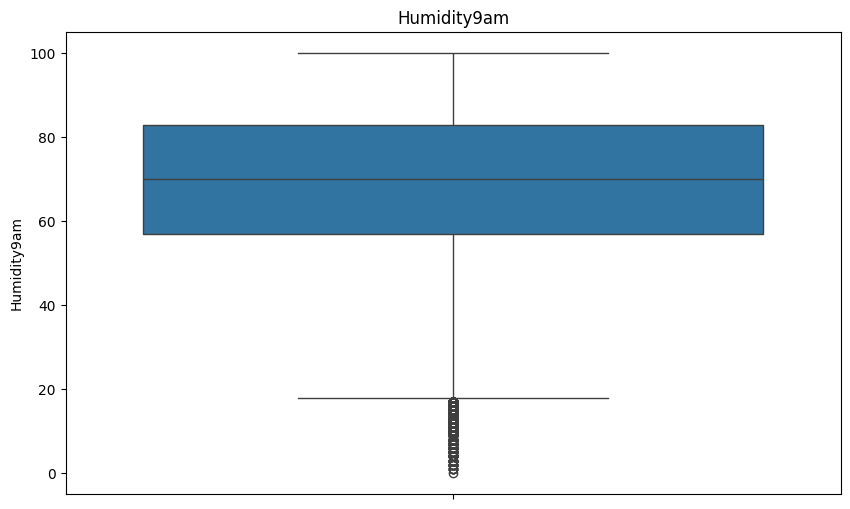

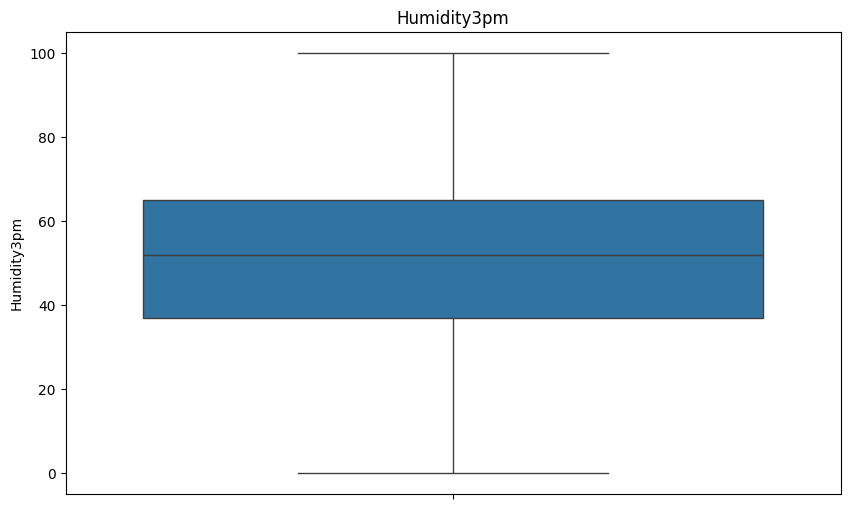

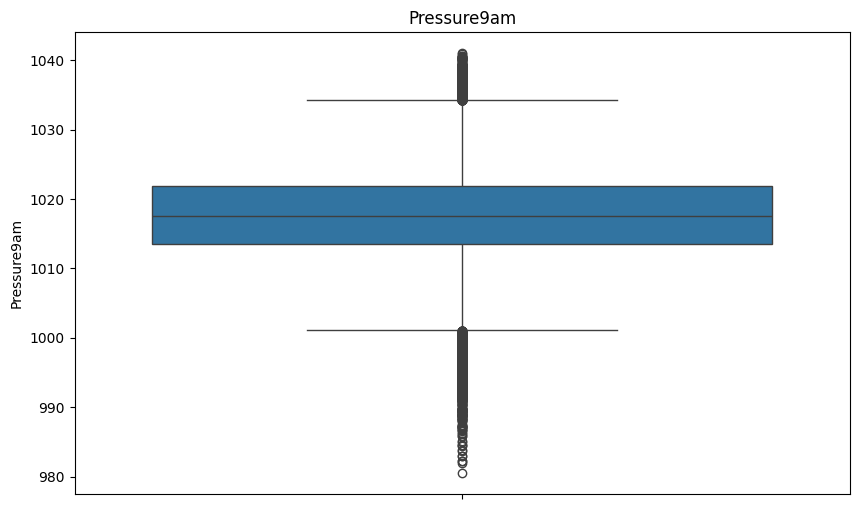

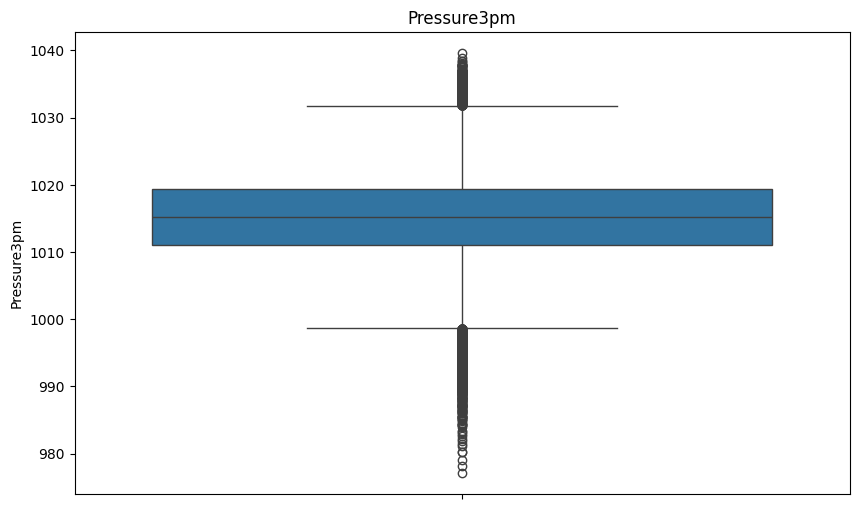

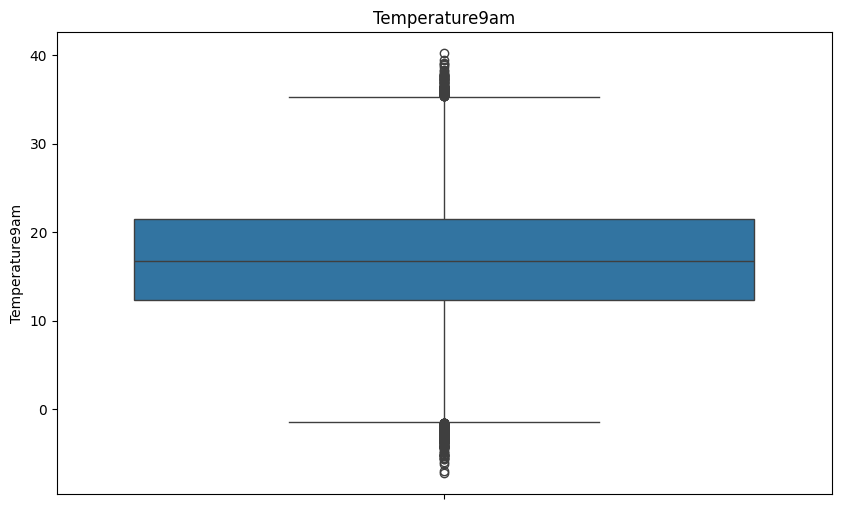

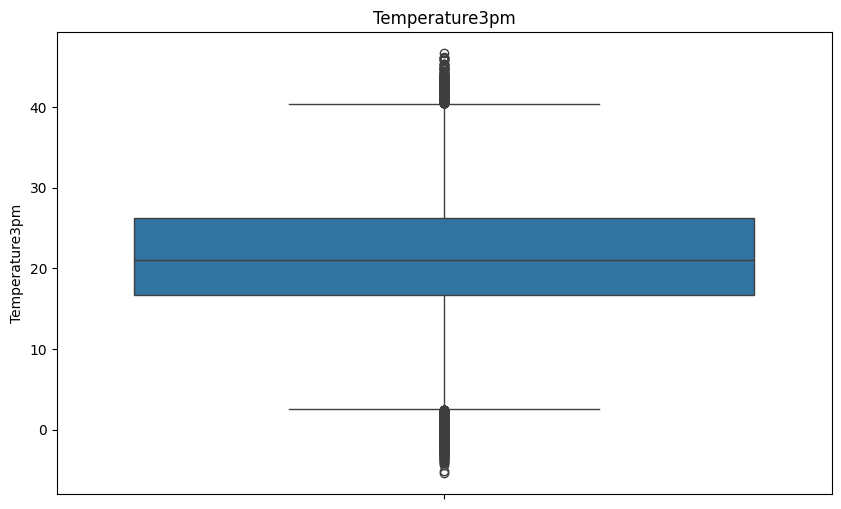

In [ ]:
for feature in continuous_feature:
    data=df.copy()
    plt.figure(figsize=(10,6))
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.show()

In [ ]:
def qq_plots(df, variable):
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

MinimumTemperature


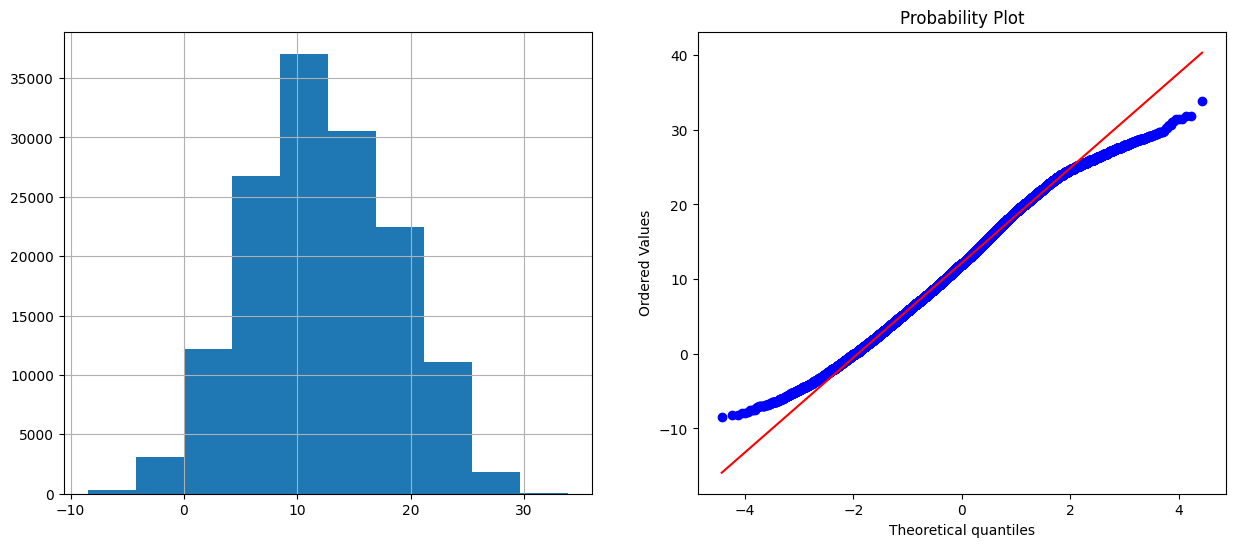

MaximumTemperature


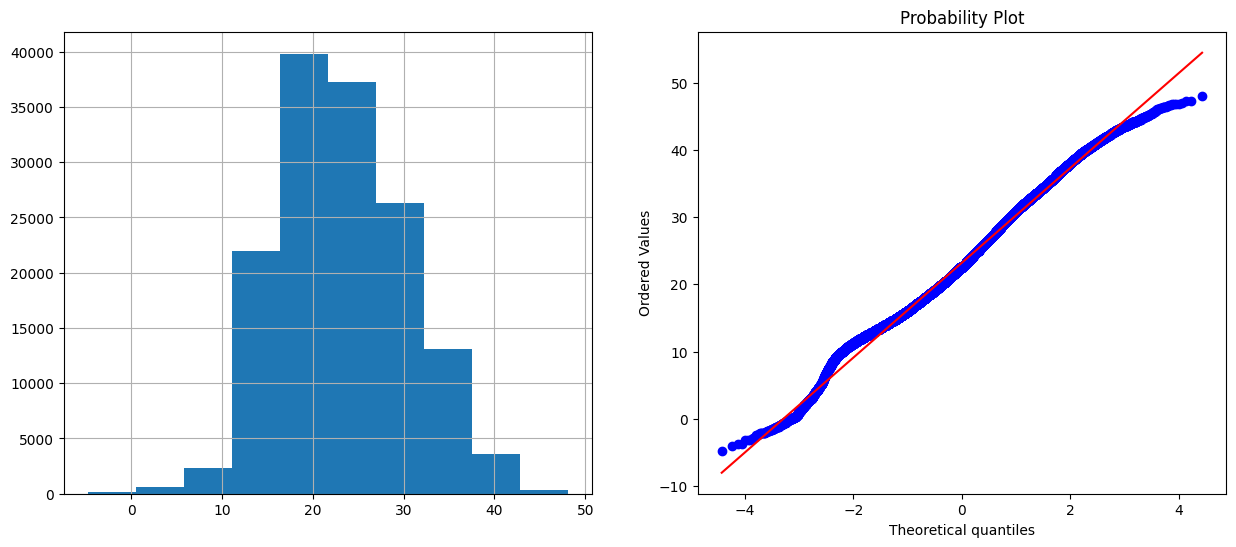

Rainfall


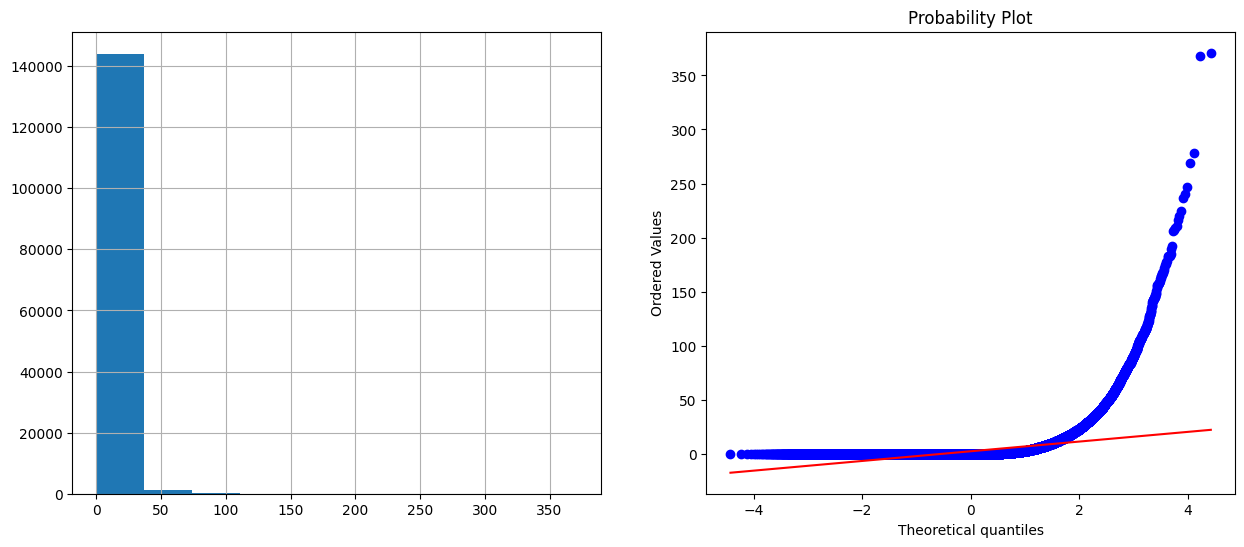

Evaporation


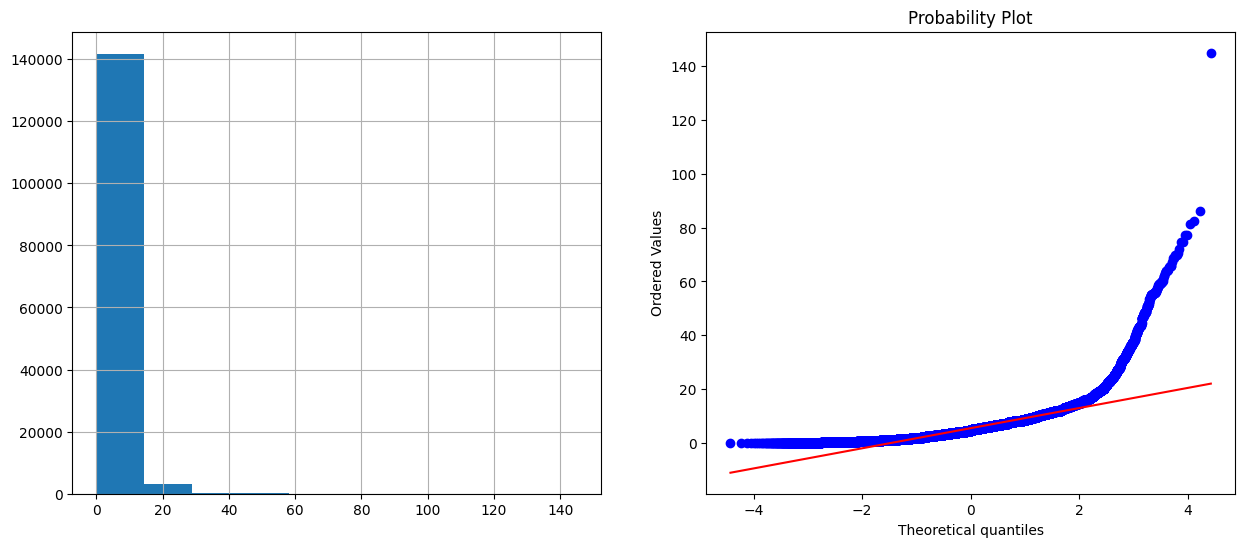

Sunshine


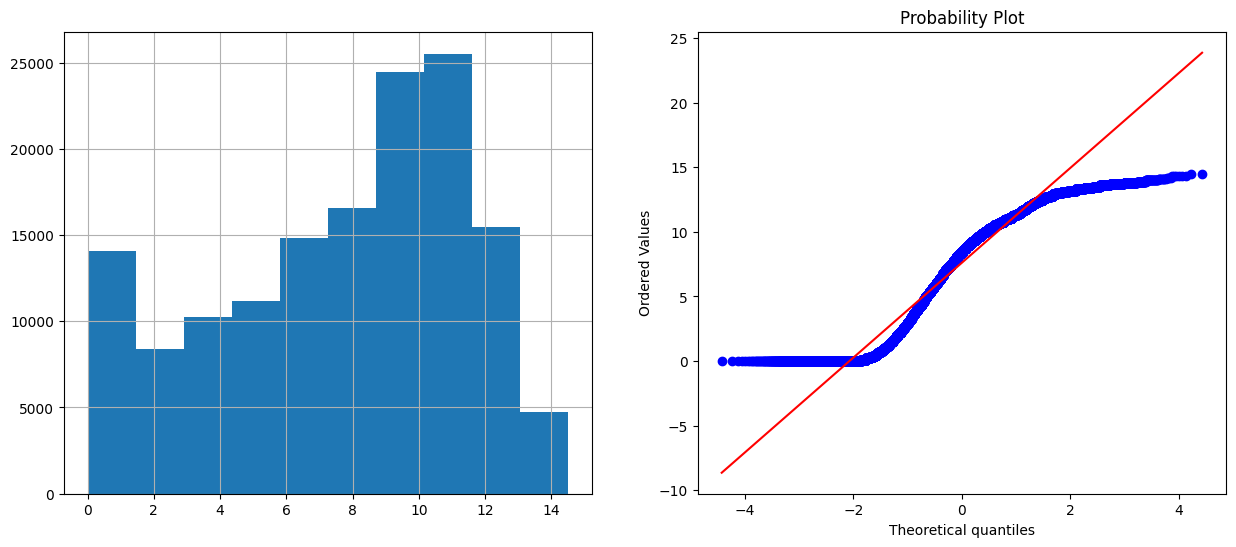

WindGustSpeed


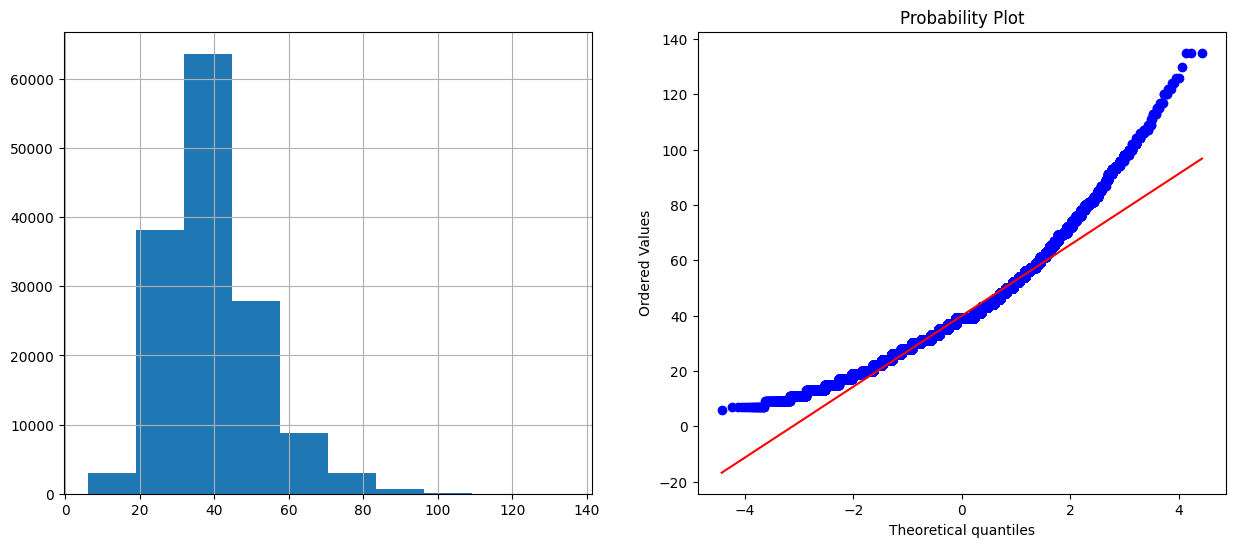

WindSpeed9am


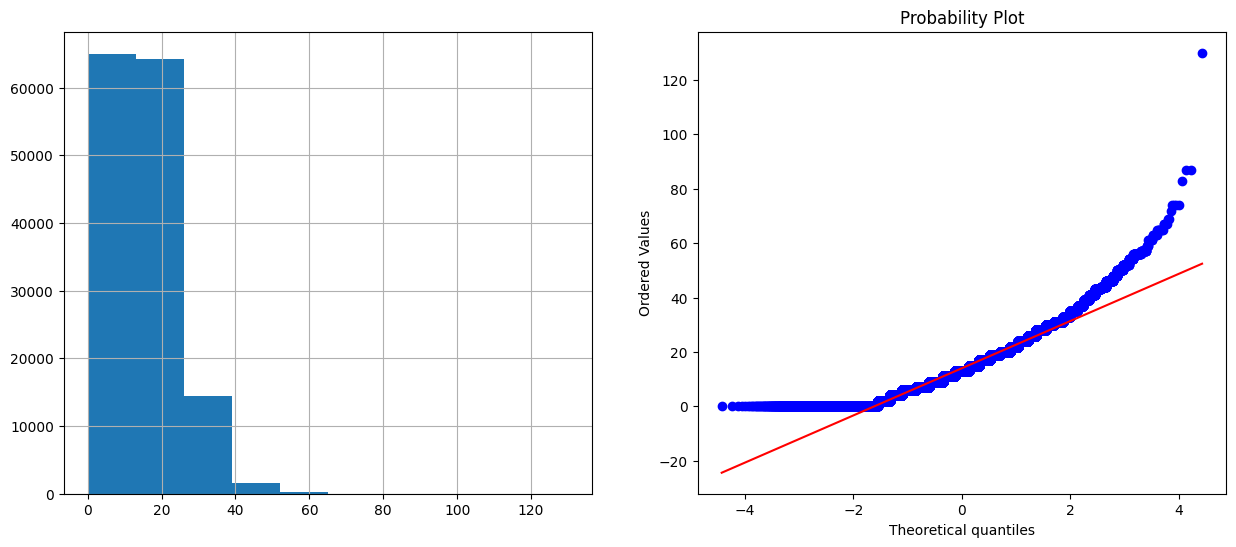

WindSpeed3pm


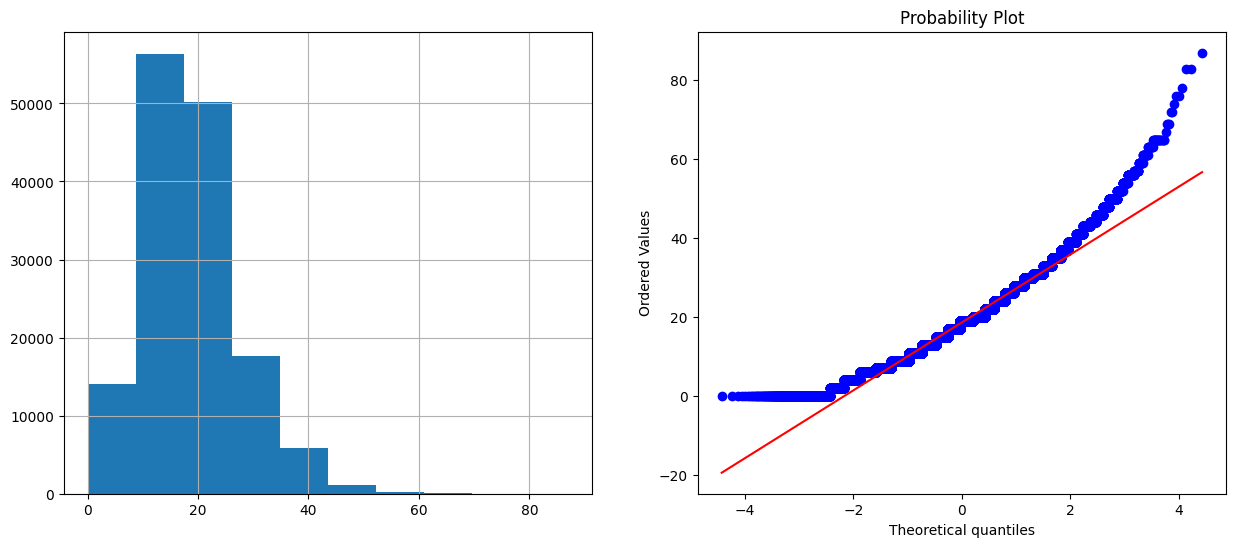

Humidity9am


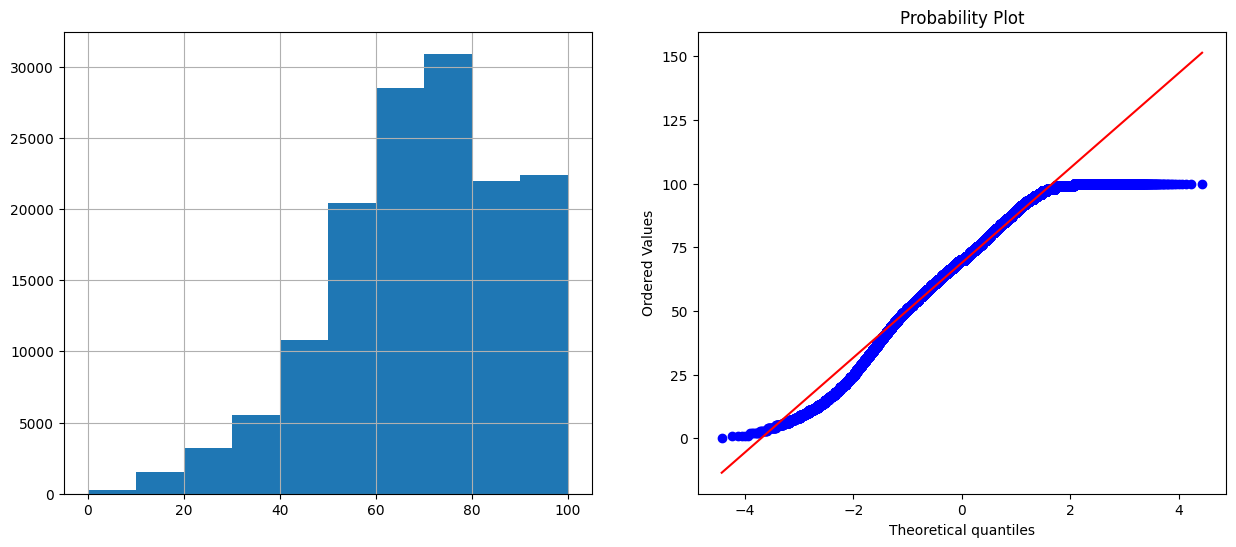

Humidity3pm


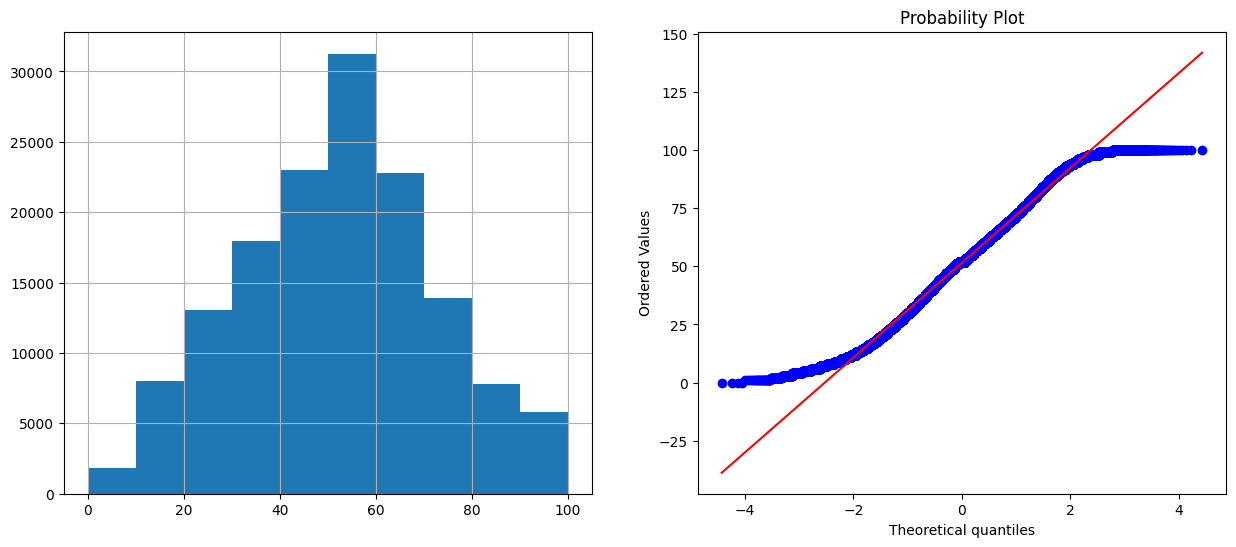

Pressure9am


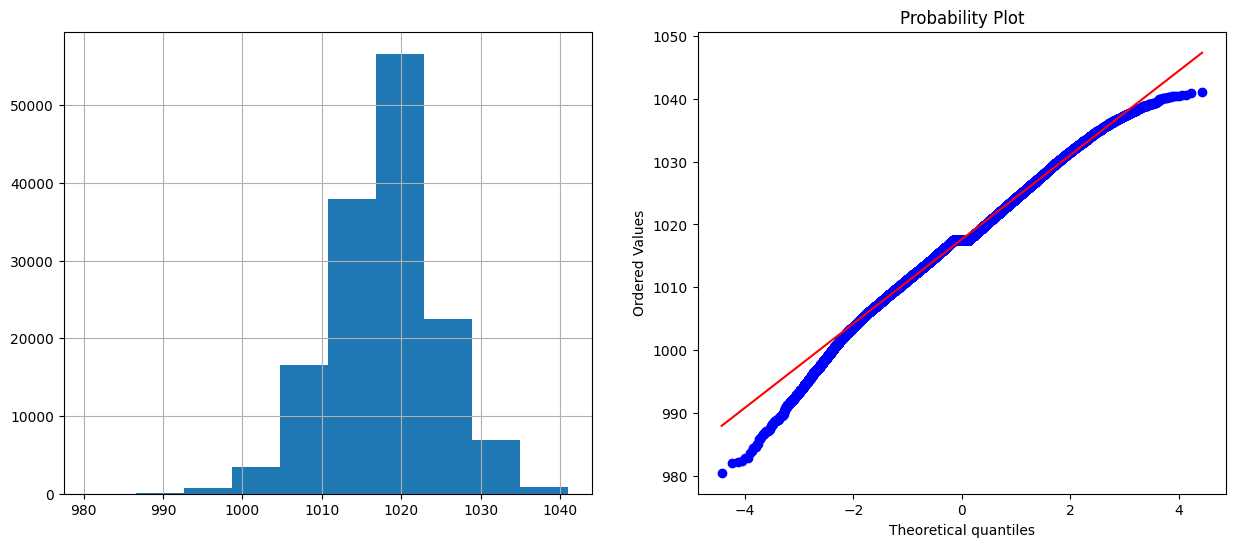

Pressure3pm


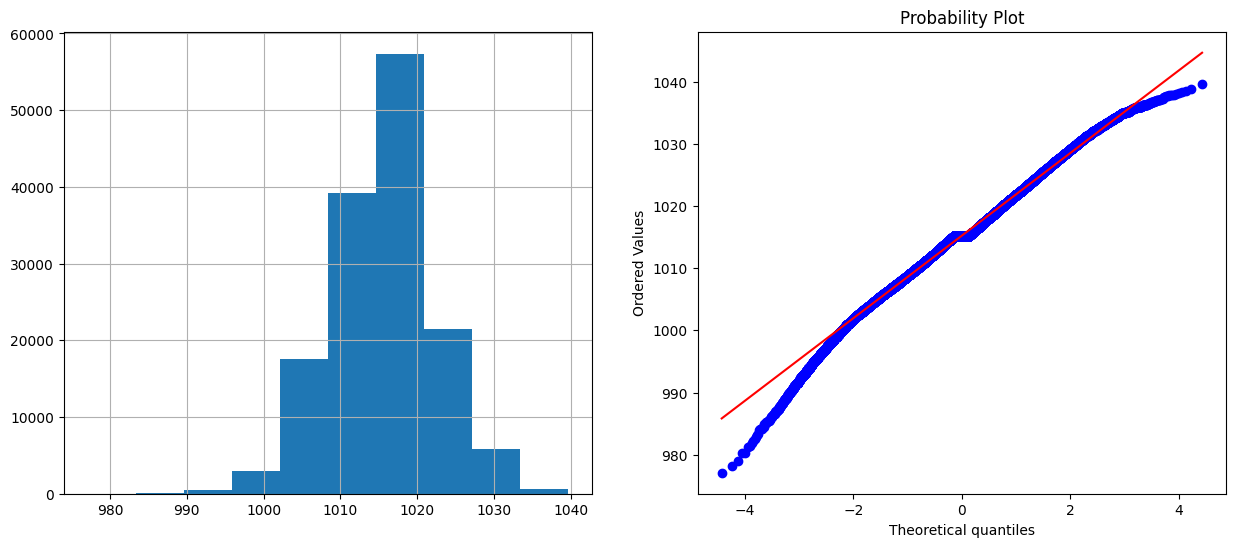

Temperature9am


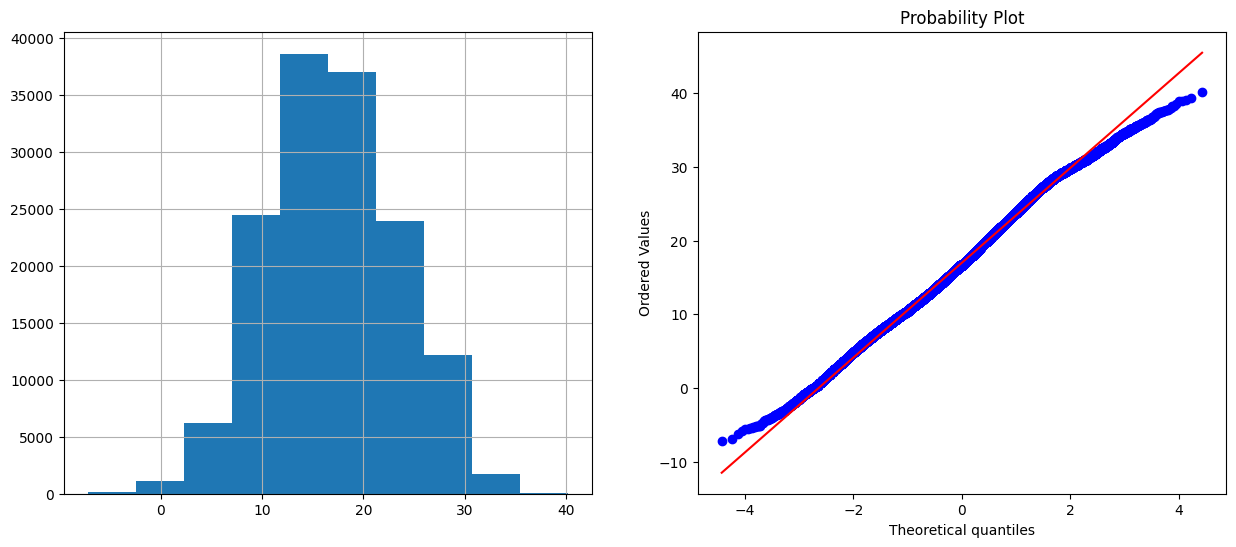

Temperature3pm


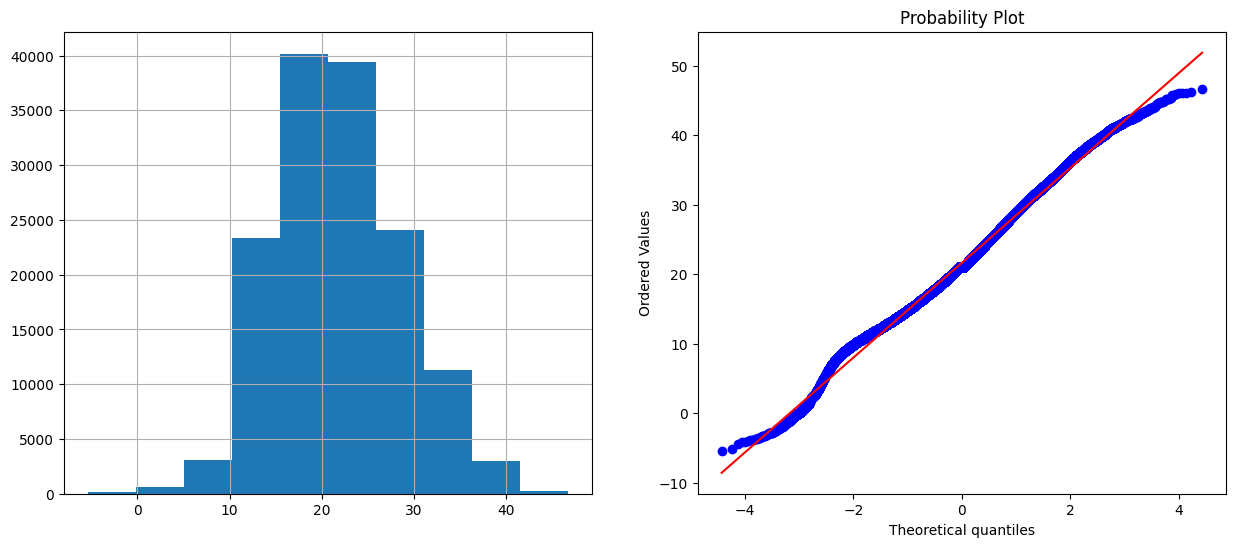

In [ ]:
for feature in continuous_feature:
    print(feature)
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[feature].hist()
    plt.subplot(1, 2, 2)
    stats.probplot(df[feature], dist="norm", plot=plt)
    plt.show()